# Project - Walker2DBulletEnv with Soft Actor Critic (SAC)

In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('Walker2DBulletEnv-v0')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## import os
## os.environ['PYTHONHASHSEED']=str(seed)

np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0003 
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, seed=seed, \
        lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(seed, replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)\

threshold = env.spec.reward_threshold

print('threshold: ', threshold)

current_dir=D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\pybullet_envs\bullet
max_steps:  1000
device:  cuda:0
state dim:  22
action dim:  Box(6,)
leraning rate:  0.0003
threshold:  2500.0


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 20000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        max_score = np.max(scores_deque)
        
        if i_episode % 100 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_chk_lr0.0003', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.3f}, Avg.Score: {:.3f}, Max.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, max_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > threshold):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 25, Ep.Steps: 25, Score: 24.647, Avg.Score: 24.647, Max.Score: 24.647, Time: 00:00:00
Ep.: 1, Total Steps: 34, Ep.Steps: 9, Score: 13.498, Avg.Score: 19.073, Max.Score: 24.647, Time: 00:00:00
Ep.: 2, Total Steps: 44, Ep.Steps: 10, Score: 14.844, Avg.Score: 17.663, Max.Score: 24.647, Time: 00:00:00
Ep.: 3, Total Steps: 59, Ep.Steps: 15, Score: 15.678, Avg.Score: 17.167, Max.Score: 24.647, Time: 00:00:00
Ep.: 4, Total Steps: 82, Ep.Steps: 23, Score: 21.126, Avg.Score: 17.958, Max.Score: 24.647, Time: 00:00:00
Ep.: 5, Total Steps: 102, Ep.Steps: 20, Score: 19.287, Avg.Score: 18.180, Max.Score: 24.647, Time: 00:00:00
Ep.: 6, Total Steps: 115, Ep.Steps: 13, Score: 15.467, Avg.Score: 17.792, Max.Score: 24.647, Time: 00:00:00
Ep.: 7, Total Steps: 142, Ep.Steps: 27, Score: 26.255, Avg.Score: 18.850, Max.Score: 26.255, Time: 00:00:00
Ep.: 8, Total Steps: 157, Ep.Steps: 15, Score: 15.391, Avg.Score: 18.466, Max.Score: 26.255, Time: 00:00:00
Ep.: 9, Total Steps: 166, Ep.Steps

Ep.: 75, Total Steps: 1068, Ep.Steps: 16, Score: 16.103, Avg.Score: 16.786, Max.Score: 27.421, Time: 00:01:00
Ep.: 76, Total Steps: 1084, Ep.Steps: 16, Score: 17.340, Avg.Score: 16.793, Max.Score: 27.421, Time: 00:01:02
Ep.: 77, Total Steps: 1097, Ep.Steps: 13, Score: 16.235, Avg.Score: 16.786, Max.Score: 27.421, Time: 00:01:03
Ep.: 78, Total Steps: 1117, Ep.Steps: 20, Score: 17.301, Avg.Score: 16.792, Max.Score: 27.421, Time: 00:01:04
Ep.: 79, Total Steps: 1127, Ep.Steps: 10, Score: 14.081, Avg.Score: 16.758, Max.Score: 27.421, Time: 00:01:05
Ep.: 80, Total Steps: 1136, Ep.Steps: 9, Score: 13.175, Avg.Score: 16.714, Max.Score: 27.421, Time: 00:01:05
Ep.: 81, Total Steps: 1145, Ep.Steps: 9, Score: 14.169, Avg.Score: 16.683, Max.Score: 27.421, Time: 00:01:06
Ep.: 82, Total Steps: 1152, Ep.Steps: 7, Score: 13.529, Avg.Score: 16.645, Max.Score: 27.421, Time: 00:01:07
Ep.: 83, Total Steps: 1172, Ep.Steps: 20, Score: 23.136, Avg.Score: 16.722, Max.Score: 27.421, Time: 00:01:08
Ep.: 84, Tota

Ep.: 149, Total Steps: 2076, Ep.Steps: 12, Score: 15.060, Avg.Score: 16.227, Max.Score: 25.942, Time: 00:02:14
Ep.: 150, Total Steps: 2095, Ep.Steps: 19, Score: 18.979, Avg.Score: 16.266, Max.Score: 25.942, Time: 00:02:16
Ep.: 151, Total Steps: 2107, Ep.Steps: 12, Score: 14.553, Avg.Score: 16.218, Max.Score: 25.942, Time: 00:02:17
Ep.: 152, Total Steps: 2118, Ep.Steps: 11, Score: 15.320, Avg.Score: 16.220, Max.Score: 25.942, Time: 00:02:17
Ep.: 153, Total Steps: 2127, Ep.Steps: 9, Score: 15.049, Avg.Score: 16.141, Max.Score: 25.942, Time: 00:02:18
Ep.: 154, Total Steps: 2138, Ep.Steps: 11, Score: 14.518, Avg.Score: 16.167, Max.Score: 25.942, Time: 00:02:19
Ep.: 155, Total Steps: 2149, Ep.Steps: 11, Score: 15.165, Avg.Score: 16.171, Max.Score: 25.942, Time: 00:02:19
Ep.: 156, Total Steps: 2160, Ep.Steps: 11, Score: 15.906, Avg.Score: 16.162, Max.Score: 25.942, Time: 00:02:20
Ep.: 157, Total Steps: 2178, Ep.Steps: 18, Score: 19.583, Avg.Score: 16.224, Max.Score: 25.942, Time: 00:02:22
Ep

Ep.: 222, Total Steps: 3106, Ep.Steps: 9, Score: 14.209, Avg.Score: 16.663, Max.Score: 43.053, Time: 00:03:30
Ep.: 223, Total Steps: 3116, Ep.Steps: 10, Score: 13.271, Avg.Score: 16.640, Max.Score: 43.053, Time: 00:03:31
Ep.: 224, Total Steps: 3133, Ep.Steps: 17, Score: 19.927, Avg.Score: 16.651, Max.Score: 43.053, Time: 00:03:32
Ep.: 225, Total Steps: 3156, Ep.Steps: 23, Score: 21.148, Avg.Score: 16.673, Max.Score: 43.053, Time: 00:03:33
Ep.: 226, Total Steps: 3164, Ep.Steps: 8, Score: 11.332, Avg.Score: 16.612, Max.Score: 43.053, Time: 00:03:34
Ep.: 227, Total Steps: 3184, Ep.Steps: 20, Score: 19.685, Avg.Score: 16.659, Max.Score: 43.053, Time: 00:03:36
Ep.: 228, Total Steps: 3194, Ep.Steps: 10, Score: 15.332, Avg.Score: 16.653, Max.Score: 43.053, Time: 00:03:36
Ep.: 229, Total Steps: 3214, Ep.Steps: 20, Score: 21.064, Avg.Score: 16.645, Max.Score: 43.053, Time: 00:03:38
Ep.: 230, Total Steps: 3233, Ep.Steps: 19, Score: 19.723, Avg.Score: 16.694, Max.Score: 43.053, Time: 00:03:39
Ep.

Ep.: 295, Total Steps: 4248, Ep.Steps: 10, Score: 13.046, Avg.Score: 17.355, Max.Score: 43.053, Time: 00:04:53
Ep.: 296, Total Steps: 4268, Ep.Steps: 20, Score: 20.044, Avg.Score: 17.406, Max.Score: 43.053, Time: 00:04:54
Ep.: 297, Total Steps: 4281, Ep.Steps: 13, Score: 17.355, Avg.Score: 17.411, Max.Score: 43.053, Time: 00:04:55
Ep.: 298, Total Steps: 4291, Ep.Steps: 10, Score: 14.667, Avg.Score: 17.406, Max.Score: 43.053, Time: 00:04:56
Ep.: 299, Total Steps: 4302, Ep.Steps: 11, Score: 14.863, Avg.Score: 17.405, Max.Score: 43.053, Time: 00:04:57
Ep.: 300, Total Steps: 4324, Ep.Steps: 22, Score: 22.551, Avg.Score: 17.508, Max.Score: 43.053, Time: 00:04:58
Ep.: 301, Total Steps: 4341, Ep.Steps: 17, Score: 19.744, Avg.Score: 17.425, Max.Score: 43.053, Time: 00:05:00
Ep.: 302, Total Steps: 4360, Ep.Steps: 19, Score: 21.690, Avg.Score: 17.498, Max.Score: 43.053, Time: 00:05:01
Ep.: 303, Total Steps: 4374, Ep.Steps: 14, Score: 17.366, Avg.Score: 17.469, Max.Score: 43.053, Time: 00:05:02
E

Ep.: 368, Total Steps: 5317, Ep.Steps: 10, Score: 12.931, Avg.Score: 16.971, Max.Score: 34.896, Time: 00:06:10
Ep.: 369, Total Steps: 5336, Ep.Steps: 19, Score: 18.938, Avg.Score: 16.990, Max.Score: 34.896, Time: 00:06:11
Ep.: 370, Total Steps: 5352, Ep.Steps: 16, Score: 17.116, Avg.Score: 16.992, Max.Score: 34.896, Time: 00:06:12
Ep.: 371, Total Steps: 5374, Ep.Steps: 22, Score: 20.274, Avg.Score: 17.046, Max.Score: 34.896, Time: 00:06:14
Ep.: 372, Total Steps: 5388, Ep.Steps: 14, Score: 17.420, Avg.Score: 17.099, Max.Score: 34.896, Time: 00:06:15
Ep.: 373, Total Steps: 5397, Ep.Steps: 9, Score: 14.244, Avg.Score: 17.068, Max.Score: 34.896, Time: 00:06:16
Ep.: 374, Total Steps: 5407, Ep.Steps: 10, Score: 14.520, Avg.Score: 17.018, Max.Score: 34.896, Time: 00:06:16
Ep.: 375, Total Steps: 5415, Ep.Steps: 8, Score: 12.877, Avg.Score: 17.001, Max.Score: 34.896, Time: 00:06:17
Ep.: 376, Total Steps: 5425, Ep.Steps: 10, Score: 13.283, Avg.Score: 16.956, Max.Score: 34.896, Time: 00:06:18
Ep.

Ep.: 441, Total Steps: 6338, Ep.Steps: 7, Score: 11.046, Avg.Score: 16.577, Max.Score: 25.517, Time: 00:07:27
Ep.: 442, Total Steps: 6349, Ep.Steps: 11, Score: 12.732, Avg.Score: 16.593, Max.Score: 25.517, Time: 00:07:28
Ep.: 443, Total Steps: 6368, Ep.Steps: 19, Score: 18.656, Avg.Score: 16.596, Max.Score: 25.517, Time: 00:07:29
Ep.: 444, Total Steps: 6379, Ep.Steps: 11, Score: 14.339, Avg.Score: 16.566, Max.Score: 25.517, Time: 00:07:30
Ep.: 445, Total Steps: 6393, Ep.Steps: 14, Score: 16.625, Avg.Score: 16.539, Max.Score: 25.517, Time: 00:07:31
Ep.: 446, Total Steps: 6402, Ep.Steps: 9, Score: 14.631, Avg.Score: 16.501, Max.Score: 25.517, Time: 00:07:32
Ep.: 447, Total Steps: 6414, Ep.Steps: 12, Score: 14.210, Avg.Score: 16.504, Max.Score: 25.517, Time: 00:07:33
Ep.: 448, Total Steps: 6427, Ep.Steps: 13, Score: 15.862, Avg.Score: 16.503, Max.Score: 25.517, Time: 00:07:34
Ep.: 449, Total Steps: 6434, Ep.Steps: 7, Score: 10.732, Avg.Score: 16.463, Max.Score: 25.517, Time: 00:07:34
Ep.:

Ep.: 514, Total Steps: 7296, Ep.Steps: 19, Score: 17.933, Avg.Score: 16.012, Max.Score: 32.937, Time: 00:08:40
Ep.: 515, Total Steps: 7314, Ep.Steps: 18, Score: 18.525, Avg.Score: 16.047, Max.Score: 32.937, Time: 00:08:42
Ep.: 516, Total Steps: 7334, Ep.Steps: 20, Score: 19.979, Avg.Score: 16.063, Max.Score: 32.937, Time: 00:08:43
Ep.: 517, Total Steps: 7343, Ep.Steps: 9, Score: 14.298, Avg.Score: 16.039, Max.Score: 32.937, Time: 00:08:44
Ep.: 518, Total Steps: 7353, Ep.Steps: 10, Score: 13.524, Avg.Score: 15.994, Max.Score: 32.937, Time: 00:08:45
Ep.: 519, Total Steps: 7376, Ep.Steps: 23, Score: 19.216, Avg.Score: 16.047, Max.Score: 32.937, Time: 00:08:46
Ep.: 520, Total Steps: 7402, Ep.Steps: 26, Score: 24.029, Avg.Score: 16.103, Max.Score: 32.937, Time: 00:08:48
Ep.: 521, Total Steps: 7429, Ep.Steps: 27, Score: 24.939, Avg.Score: 16.152, Max.Score: 32.937, Time: 00:08:50
Ep.: 522, Total Steps: 7457, Ep.Steps: 28, Score: 25.160, Avg.Score: 16.260, Max.Score: 32.937, Time: 00:08:52
Ep

Ep.: 587, Total Steps: 8393, Ep.Steps: 7, Score: 12.853, Avg.Score: 17.007, Max.Score: 32.937, Time: 00:09:59
Ep.: 588, Total Steps: 8403, Ep.Steps: 10, Score: 13.315, Avg.Score: 16.981, Max.Score: 32.937, Time: 00:10:00
Ep.: 589, Total Steps: 8414, Ep.Steps: 11, Score: 15.702, Avg.Score: 16.920, Max.Score: 32.937, Time: 00:10:00
Ep.: 590, Total Steps: 8426, Ep.Steps: 12, Score: 16.276, Avg.Score: 16.915, Max.Score: 32.937, Time: 00:10:01
Ep.: 591, Total Steps: 8433, Ep.Steps: 7, Score: 12.881, Avg.Score: 16.852, Max.Score: 32.937, Time: 00:10:02
Ep.: 592, Total Steps: 8441, Ep.Steps: 8, Score: 12.218, Avg.Score: 16.645, Max.Score: 25.160, Time: 00:10:02
Ep.: 593, Total Steps: 8457, Ep.Steps: 16, Score: 20.072, Avg.Score: 16.727, Max.Score: 25.160, Time: 00:10:04
Ep.: 594, Total Steps: 8475, Ep.Steps: 18, Score: 19.226, Avg.Score: 16.793, Max.Score: 25.160, Time: 00:10:05
Ep.: 595, Total Steps: 8483, Ep.Steps: 8, Score: 12.716, Avg.Score: 16.777, Max.Score: 25.160, Time: 00:10:06
Ep.: 

Ep.: 660, Total Steps: 9424, Ep.Steps: 22, Score: 19.294, Avg.Score: 16.438, Max.Score: 24.394, Time: 00:11:13
Ep.: 661, Total Steps: 9445, Ep.Steps: 21, Score: 20.165, Avg.Score: 16.495, Max.Score: 24.394, Time: 00:11:15
Ep.: 662, Total Steps: 9454, Ep.Steps: 9, Score: 13.856, Avg.Score: 16.486, Max.Score: 24.394, Time: 00:11:16
Ep.: 663, Total Steps: 9470, Ep.Steps: 16, Score: 17.712, Avg.Score: 16.448, Max.Score: 24.394, Time: 00:11:17
Ep.: 664, Total Steps: 9484, Ep.Steps: 14, Score: 17.891, Avg.Score: 16.471, Max.Score: 24.394, Time: 00:11:18
Ep.: 665, Total Steps: 9502, Ep.Steps: 18, Score: 18.560, Avg.Score: 16.499, Max.Score: 24.394, Time: 00:11:19
Ep.: 666, Total Steps: 9521, Ep.Steps: 19, Score: 21.235, Avg.Score: 16.549, Max.Score: 24.394, Time: 00:11:20
Ep.: 667, Total Steps: 9534, Ep.Steps: 13, Score: 14.224, Avg.Score: 16.494, Max.Score: 24.394, Time: 00:11:21
Ep.: 668, Total Steps: 9541, Ep.Steps: 7, Score: 11.622, Avg.Score: 16.459, Max.Score: 24.394, Time: 00:11:22
Ep.

Ep.: 733, Total Steps: 12422, Ep.Steps: 52, Score: 64.538, Avg.Score: 27.242, Max.Score: 102.457, Time: 00:15:07
Ep.: 734, Total Steps: 12500, Ep.Steps: 78, Score: 91.850, Avg.Score: 28.042, Max.Score: 102.457, Time: 00:15:13
Ep.: 735, Total Steps: 12556, Ep.Steps: 56, Score: 66.791, Avg.Score: 28.575, Max.Score: 102.457, Time: 00:15:18
Ep.: 736, Total Steps: 12619, Ep.Steps: 63, Score: 70.905, Avg.Score: 29.147, Max.Score: 102.457, Time: 00:15:23
Ep.: 737, Total Steps: 12690, Ep.Steps: 71, Score: 81.955, Avg.Score: 29.815, Max.Score: 102.457, Time: 00:15:33
Ep.: 738, Total Steps: 12773, Ep.Steps: 83, Score: 96.526, Avg.Score: 30.625, Max.Score: 102.457, Time: 00:15:39
Ep.: 739, Total Steps: 12843, Ep.Steps: 70, Score: 79.488, Avg.Score: 31.250, Max.Score: 102.457, Time: 00:15:46
Ep.: 740, Total Steps: 12916, Ep.Steps: 73, Score: 28.728, Avg.Score: 31.393, Max.Score: 102.457, Time: 00:15:59
Ep.: 741, Total Steps: 13039, Ep.Steps: 123, Score: 110.342, Avg.Score: 32.274, Max.Score: 110.3

Ep.: 805, Total Steps: 18816, Ep.Steps: 69, Score: 84.061, Avg.Score: 72.100, Max.Score: 267.031, Time: 00:24:19
Ep.: 806, Total Steps: 18875, Ep.Steps: 59, Score: 75.547, Avg.Score: 72.634, Max.Score: 267.031, Time: 00:24:24
Ep.: 807, Total Steps: 18953, Ep.Steps: 78, Score: 93.440, Avg.Score: 73.394, Max.Score: 267.031, Time: 00:24:30
Ep.: 808, Total Steps: 19038, Ep.Steps: 85, Score: 35.449, Avg.Score: 73.365, Max.Score: 267.031, Time: 00:24:39
Ep.: 809, Total Steps: 19109, Ep.Steps: 71, Score: 88.067, Avg.Score: 73.673, Max.Score: 267.031, Time: 00:24:46
Ep.: 810, Total Steps: 19171, Ep.Steps: 62, Score: 81.915, Avg.Score: 74.083, Max.Score: 267.031, Time: 00:24:52
Ep.: 811, Total Steps: 19288, Ep.Steps: 117, Score: 125.624, Avg.Score: 74.476, Max.Score: 267.031, Time: 00:25:04
Ep.: 812, Total Steps: 19358, Ep.Steps: 70, Score: 86.665, Avg.Score: 74.617, Max.Score: 267.031, Time: 00:25:11
Ep.: 813, Total Steps: 19473, Ep.Steps: 115, Score: 51.493, Avg.Score: 74.513, Max.Score: 267.

Ep.: 877, Total Steps: 25624, Ep.Steps: 90, Score: 33.166, Avg.Score: 73.225, Max.Score: 152.660, Time: 00:33:56
Ep.: 878, Total Steps: 25752, Ep.Steps: 128, Score: 127.848, Avg.Score: 73.690, Max.Score: 152.660, Time: 00:34:06
Ep.: 879, Total Steps: 25819, Ep.Steps: 67, Score: 39.772, Avg.Score: 73.081, Max.Score: 152.660, Time: 00:34:12
Ep.: 880, Total Steps: 25923, Ep.Steps: 104, Score: 37.949, Avg.Score: 72.706, Max.Score: 152.660, Time: 00:34:20
Ep.: 881, Total Steps: 26010, Ep.Steps: 87, Score: 40.985, Avg.Score: 72.303, Max.Score: 152.660, Time: 00:34:27
Ep.: 882, Total Steps: 26104, Ep.Steps: 94, Score: 34.804, Avg.Score: 71.934, Max.Score: 152.660, Time: 00:34:34
Ep.: 883, Total Steps: 26454, Ep.Steps: 350, Score: 314.963, Avg.Score: 74.330, Max.Score: 314.963, Time: 00:35:02
Ep.: 884, Total Steps: 26908, Ep.Steps: 454, Score: 396.146, Avg.Score: 77.702, Max.Score: 396.146, Time: 00:35:38
Ep.: 885, Total Steps: 27003, Ep.Steps: 95, Score: 40.957, Avg.Score: 77.288, Max.Score: 

Ep.: 948, Total Steps: 38521, Ep.Steps: 132, Score: 137.917, Avg.Score: 117.199, Max.Score: 766.110, Time: 00:50:57
Ep.: 949, Total Steps: 38731, Ep.Steps: 210, Score: 194.874, Avg.Score: 118.618, Max.Score: 766.110, Time: 00:51:14
Ep.: 950, Total Steps: 38826, Ep.Steps: 95, Score: 107.637, Avg.Score: 118.858, Max.Score: 766.110, Time: 00:51:21
Ep.: 951, Total Steps: 39009, Ep.Steps: 183, Score: 180.379, Avg.Score: 119.714, Max.Score: 766.110, Time: 00:51:36
Ep.: 952, Total Steps: 39159, Ep.Steps: 150, Score: 53.728, Avg.Score: 119.676, Max.Score: 766.110, Time: 00:51:46
Ep.: 953, Total Steps: 39221, Ep.Steps: 62, Score: 17.747, Avg.Score: 119.586, Max.Score: 766.110, Time: 00:51:49
Ep.: 954, Total Steps: 39335, Ep.Steps: 114, Score: 122.639, Avg.Score: 119.572, Max.Score: 766.110, Time: 00:51:55
Ep.: 955, Total Steps: 39384, Ep.Steps: 49, Score: 19.216, Avg.Score: 119.189, Max.Score: 766.110, Time: 00:51:58
Ep.: 956, Total Steps: 39502, Ep.Steps: 118, Score: 126.361, Avg.Score: 120.05

Ep.: 1018, Total Steps: 52282, Ep.Steps: 143, Score: 139.619, Avg.Score: 166.608, Max.Score: 809.965, Time: 01:03:21
Ep.: 1019, Total Steps: 52538, Ep.Steps: 256, Score: 238.661, Avg.Score: 168.449, Max.Score: 809.965, Time: 01:03:35
Ep.: 1020, Total Steps: 52756, Ep.Steps: 218, Score: 204.323, Avg.Score: 169.442, Max.Score: 809.965, Time: 01:03:46
Ep.: 1021, Total Steps: 53444, Ep.Steps: 688, Score: 383.644, Avg.Score: 172.515, Max.Score: 809.965, Time: 01:04:23
Ep.: 1022, Total Steps: 53932, Ep.Steps: 488, Score: 311.106, Avg.Score: 174.906, Max.Score: 809.965, Time: 01:04:48
Ep.: 1023, Total Steps: 54021, Ep.Steps: 89, Score: 97.947, Avg.Score: 168.230, Max.Score: 809.965, Time: 01:04:53
Ep.: 1024, Total Steps: 54932, Ep.Steps: 911, Score: 749.000, Avg.Score: 168.059, Max.Score: 809.965, Time: 01:05:41
Ep.: 1025, Total Steps: 55106, Ep.Steps: 174, Score: 181.117, Avg.Score: 169.304, Max.Score: 809.965, Time: 01:05:51
Ep.: 1026, Total Steps: 56106, Ep.Steps: 1000, Score: 618.933, Avg

Ep.: 1088, Total Steps: 75281, Ep.Steps: 338, Score: 327.235, Avg.Score: 245.810, Max.Score: 896.788, Time: 01:23:33
Ep.: 1089, Total Steps: 76281, Ep.Steps: 1000, Score: 848.941, Avg.Score: 252.618, Max.Score: 896.788, Time: 01:24:27
Ep.: 1090, Total Steps: 77281, Ep.Steps: 1000, Score: 947.524, Avg.Score: 260.361, Max.Score: 947.524, Time: 01:25:19
Ep.: 1091, Total Steps: 78281, Ep.Steps: 1000, Score: 864.616, Avg.Score: 267.026, Max.Score: 947.524, Time: 01:26:11
Ep.: 1092, Total Steps: 78598, Ep.Steps: 317, Score: 320.474, Avg.Score: 269.315, Max.Score: 947.524, Time: 01:26:27
Ep.: 1093, Total Steps: 78769, Ep.Steps: 171, Score: 177.035, Avg.Score: 270.295, Max.Score: 947.524, Time: 01:26:36
Ep.: 1094, Total Steps: 78938, Ep.Steps: 169, Score: 178.638, Avg.Score: 267.032, Max.Score: 947.524, Time: 01:26:44
Ep.: 1095, Total Steps: 79938, Ep.Steps: 1000, Score: 876.709, Avg.Score: 273.083, Max.Score: 947.524, Time: 01:27:35
Ep.: 1096, Total Steps: 79982, Ep.Steps: 44, Score: 23.740, 

Ep.: 1157, Total Steps: 119358, Ep.Steps: 1000, Score: 976.250, Avg.Score: 516.277, Max.Score: 986.610, Time: 02:01:12
Ep.: 1158, Total Steps: 119783, Ep.Steps: 425, Score: 425.630, Avg.Score: 519.438, Max.Score: 986.610, Time: 02:01:35
Ep.: 1159, Total Steps: 120280, Ep.Steps: 497, Score: 490.408, Avg.Score: 523.030, Max.Score: 986.610, Time: 02:02:01
Ep.: 1160, Total Steps: 120733, Ep.Steps: 453, Score: 438.957, Avg.Score: 524.146, Max.Score: 986.610, Time: 02:02:24
Ep.: 1161, Total Steps: 120887, Ep.Steps: 154, Score: 160.971, Avg.Score: 524.279, Max.Score: 986.610, Time: 02:02:32
Ep.: 1162, Total Steps: 121887, Ep.Steps: 1000, Score: 970.642, Avg.Score: 533.049, Max.Score: 986.610, Time: 02:03:23
Ep.: 1163, Total Steps: 122887, Ep.Steps: 1000, Score: 967.933, Avg.Score: 540.758, Max.Score: 986.610, Time: 02:04:15
Ep.: 1164, Total Steps: 123887, Ep.Steps: 1000, Score: 969.946, Avg.Score: 550.110, Max.Score: 986.610, Time: 02:05:06
Ep.: 1165, Total Steps: 124628, Ep.Steps: 741, Score

Ep.: 1226, Total Steps: 152478, Ep.Steps: 792, Score: 721.584, Avg.Score: 539.397, Max.Score: 986.610, Time: 02:29:28
Ep.: 1227, Total Steps: 152783, Ep.Steps: 305, Score: 300.401, Avg.Score: 541.914, Max.Score: 986.610, Time: 02:29:44
Ep.: 1228, Total Steps: 153309, Ep.Steps: 526, Score: 493.278, Avg.Score: 537.246, Max.Score: 986.610, Time: 02:30:11
Ep.: 1229, Total Steps: 153742, Ep.Steps: 433, Score: 379.564, Avg.Score: 531.483, Max.Score: 986.610, Time: 02:30:33
Ep.: 1230, Total Steps: 154742, Ep.Steps: 1000, Score: 844.310, Avg.Score: 532.525, Max.Score: 986.610, Time: 02:31:26
Ep.: 1231, Total Steps: 155742, Ep.Steps: 1000, Score: 916.642, Avg.Score: 540.138, Max.Score: 986.610, Time: 02:32:17
Ep.: 1232, Total Steps: 156742, Ep.Steps: 1000, Score: 956.259, Avg.Score: 540.155, Max.Score: 986.610, Time: 02:33:09
Ep.: 1233, Total Steps: 156983, Ep.Steps: 241, Score: 249.314, Avg.Score: 532.987, Max.Score: 986.610, Time: 02:33:21
Ep.: 1234, Total Steps: 157178, Ep.Steps: 195, Score:

Ep.: 1295, Total Steps: 185615, Ep.Steps: 149, Score: 154.082, Avg.Score: 454.033, Max.Score: 985.621, Time: 02:59:13
Ep.: 1296, Total Steps: 186615, Ep.Steps: 1000, Score: 968.563, Avg.Score: 454.520, Max.Score: 985.621, Time: 03:00:17
Ep.: 1297, Total Steps: 187221, Ep.Steps: 606, Score: 599.199, Avg.Score: 456.058, Max.Score: 985.621, Time: 03:00:57
Ep.: 1298, Total Steps: 187850, Ep.Steps: 629, Score: 463.724, Avg.Score: 458.720, Max.Score: 985.621, Time: 03:01:36
Ep.: 1299, Total Steps: 188562, Ep.Steps: 712, Score: 700.878, Avg.Score: 464.354, Max.Score: 985.621, Time: 03:02:19
Ep.: 1300, Total Steps: 189520, Ep.Steps: 958, Score: 942.565, Avg.Score: 472.461, Max.Score: 985.621, Time: 03:03:16
Ep.: 1301, Total Steps: 190520, Ep.Steps: 1000, Score: 942.045, Avg.Score: 479.488, Max.Score: 985.621, Time: 03:04:16
Ep.: 1302, Total Steps: 191377, Ep.Steps: 857, Score: 852.772, Avg.Score: 486.870, Max.Score: 985.621, Time: 03:05:07
Ep.: 1303, Total Steps: 192377, Ep.Steps: 1000, Score:

Ep.: 1364, Total Steps: 245134, Ep.Steps: 1000, Score: 930.872, Avg.Score: 664.531, Max.Score: 980.538, Time: 03:55:40
Ep.: 1365, Total Steps: 246134, Ep.Steps: 1000, Score: 956.389, Avg.Score: 671.180, Max.Score: 980.538, Time: 03:56:37
Ep.: 1366, Total Steps: 247134, Ep.Steps: 1000, Score: 963.687, Avg.Score: 678.899, Max.Score: 980.538, Time: 03:57:34
Ep.: 1367, Total Steps: 248134, Ep.Steps: 1000, Score: 972.394, Avg.Score: 686.309, Max.Score: 980.538, Time: 03:58:31
Ep.: 1368, Total Steps: 249134, Ep.Steps: 1000, Score: 950.789, Avg.Score: 693.889, Max.Score: 980.538, Time: 03:59:28
Ep.: 1369, Total Steps: 250134, Ep.Steps: 1000, Score: 956.431, Avg.Score: 695.700, Max.Score: 980.538, Time: 04:00:27
Ep.: 1370, Total Steps: 251134, Ep.Steps: 1000, Score: 882.076, Avg.Score: 702.802, Max.Score: 980.538, Time: 04:01:24
Ep.: 1371, Total Steps: 252134, Ep.Steps: 1000, Score: 953.966, Avg.Score: 711.936, Max.Score: 980.538, Time: 04:02:21
Ep.: 1372, Total Steps: 253134, Ep.Steps: 1000, 

Ep.: 1432, Total Steps: 310310, Ep.Steps: 1000, Score: 895.336, Avg.Score: 866.318, Max.Score: 977.074, Time: 04:52:45
Ep.: 1433, Total Steps: 310666, Ep.Steps: 356, Score: 354.668, Avg.Score: 860.725, Max.Score: 977.074, Time: 04:53:03
Ep.: 1434, Total Steps: 311666, Ep.Steps: 1000, Score: 968.404, Avg.Score: 860.749, Max.Score: 977.074, Time: 04:53:54
Ep.: 1435, Total Steps: 311995, Ep.Steps: 329, Score: 326.538, Avg.Score: 862.495, Max.Score: 977.074, Time: 04:54:10
Ep.: 1436, Total Steps: 312995, Ep.Steps: 1000, Score: 983.069, Avg.Score: 863.082, Max.Score: 983.069, Time: 04:55:01
Ep.: 1437, Total Steps: 313995, Ep.Steps: 1000, Score: 886.463, Avg.Score: 862.355, Max.Score: 983.069, Time: 04:55:51
Ep.: 1438, Total Steps: 314995, Ep.Steps: 1000, Score: 941.995, Avg.Score: 862.244, Max.Score: 983.069, Time: 04:56:42
Ep.: 1439, Total Steps: 315995, Ep.Steps: 1000, Score: 915.851, Avg.Score: 862.068, Max.Score: 983.069, Time: 04:57:32
Ep.: 1440, Total Steps: 316995, Ep.Steps: 1000, Sc

Ep.: 1500, Total Steps: 373154, Ep.Steps: 1000, Score: 953.523, Avg.Score: 868.301, Max.Score: 988.983, Time: 05:45:42
Ep.: 1501, Total Steps: 374154, Ep.Steps: 1000, Score: 928.418, Avg.Score: 869.433, Max.Score: 988.983, Time: 05:46:33
Ep.: 1502, Total Steps: 375154, Ep.Steps: 1000, Score: 986.679, Avg.Score: 869.529, Max.Score: 988.983, Time: 05:47:23
Ep.: 1503, Total Steps: 376154, Ep.Steps: 1000, Score: 973.847, Avg.Score: 870.045, Max.Score: 988.983, Time: 05:48:14
Ep.: 1504, Total Steps: 377154, Ep.Steps: 1000, Score: 965.485, Avg.Score: 870.112, Max.Score: 988.983, Time: 05:49:08
Ep.: 1505, Total Steps: 378154, Ep.Steps: 1000, Score: 879.012, Avg.Score: 869.420, Max.Score: 988.983, Time: 05:50:00
Ep.: 1506, Total Steps: 378954, Ep.Steps: 800, Score: 766.641, Avg.Score: 868.076, Max.Score: 988.983, Time: 05:50:41
Ep.: 1507, Total Steps: 379954, Ep.Steps: 1000, Score: 968.807, Avg.Score: 868.096, Max.Score: 988.983, Time: 05:51:31
Ep.: 1508, Total Steps: 380954, Ep.Steps: 1000, S

Ep.: 1568, Total Steps: 437708, Ep.Steps: 1000, Score: 984.231, Avg.Score: 904.748, Max.Score: 992.229, Time: 06:40:18
Ep.: 1569, Total Steps: 438708, Ep.Steps: 1000, Score: 972.791, Avg.Score: 905.371, Max.Score: 992.229, Time: 06:41:09
Ep.: 1570, Total Steps: 439708, Ep.Steps: 1000, Score: 961.752, Avg.Score: 906.515, Max.Score: 992.229, Time: 06:42:00
Ep.: 1571, Total Steps: 440708, Ep.Steps: 1000, Score: 942.892, Avg.Score: 906.983, Max.Score: 992.229, Time: 06:42:50
Ep.: 1572, Total Steps: 441708, Ep.Steps: 1000, Score: 978.343, Avg.Score: 908.028, Max.Score: 992.229, Time: 06:43:41
Ep.: 1573, Total Steps: 442708, Ep.Steps: 1000, Score: 907.105, Avg.Score: 908.525, Max.Score: 992.229, Time: 06:44:32
Ep.: 1574, Total Steps: 443708, Ep.Steps: 1000, Score: 984.305, Avg.Score: 909.078, Max.Score: 992.229, Time: 06:45:22
Ep.: 1575, Total Steps: 444579, Ep.Steps: 871, Score: 863.011, Avg.Score: 908.007, Max.Score: 992.229, Time: 06:46:07
Ep.: 1576, Total Steps: 445579, Ep.Steps: 1000, S

Ep.: 1636, Total Steps: 499668, Ep.Steps: 1000, Score: 959.456, Avg.Score: 874.180, Max.Score: 993.147, Time: 07:33:03
Ep.: 1637, Total Steps: 500668, Ep.Steps: 1000, Score: 916.502, Avg.Score: 873.659, Max.Score: 993.147, Time: 07:33:57
Ep.: 1638, Total Steps: 501668, Ep.Steps: 1000, Score: 933.851, Avg.Score: 873.339, Max.Score: 993.147, Time: 07:34:57
Ep.: 1639, Total Steps: 502668, Ep.Steps: 1000, Score: 928.798, Avg.Score: 882.426, Max.Score: 993.147, Time: 07:35:56
Ep.: 1640, Total Steps: 503668, Ep.Steps: 1000, Score: 831.465, Avg.Score: 881.128, Max.Score: 993.147, Time: 07:36:50
Ep.: 1641, Total Steps: 504668, Ep.Steps: 1000, Score: 911.328, Avg.Score: 880.373, Max.Score: 993.147, Time: 07:37:42
Ep.: 1642, Total Steps: 505668, Ep.Steps: 1000, Score: 909.191, Avg.Score: 879.604, Max.Score: 993.147, Time: 07:38:33
Ep.: 1643, Total Steps: 506668, Ep.Steps: 1000, Score: 900.659, Avg.Score: 878.868, Max.Score: 993.147, Time: 07:39:25
Ep.: 1644, Total Steps: 506766, Ep.Steps: 98, Sc

Ep.: 1704, Total Steps: 563923, Ep.Steps: 1000, Score: 979.532, Avg.Score: 873.793, Max.Score: 1011.502, Time: 08:30:44
Ep.: 1705, Total Steps: 564923, Ep.Steps: 1000, Score: 971.795, Avg.Score: 873.599, Max.Score: 1011.502, Time: 08:31:41
Ep.: 1706, Total Steps: 565923, Ep.Steps: 1000, Score: 967.168, Avg.Score: 873.783, Max.Score: 1011.502, Time: 08:32:39
Ep.: 1707, Total Steps: 566923, Ep.Steps: 1000, Score: 924.003, Avg.Score: 873.281, Max.Score: 1011.502, Time: 08:33:34
Ep.: 1708, Total Steps: 567923, Ep.Steps: 1000, Score: 869.499, Avg.Score: 872.215, Max.Score: 1011.502, Time: 08:34:25
Ep.: 1709, Total Steps: 568923, Ep.Steps: 1000, Score: 901.956, Avg.Score: 871.614, Max.Score: 1011.502, Time: 08:35:15
Ep.: 1710, Total Steps: 569923, Ep.Steps: 1000, Score: 954.836, Avg.Score: 871.562, Max.Score: 1011.502, Time: 08:36:06
Ep.: 1711, Total Steps: 570923, Ep.Steps: 1000, Score: 823.931, Avg.Score: 870.537, Max.Score: 1011.502, Time: 08:36:59
Ep.: 1712, Total Steps: 571923, Ep.Steps

Ep.: 1772, Total Steps: 625927, Ep.Steps: 1000, Score: 976.761, Avg.Score: 896.867, Max.Score: 998.709, Time: 09:22:58
Ep.: 1773, Total Steps: 626927, Ep.Steps: 1000, Score: 982.523, Avg.Score: 896.705, Max.Score: 994.457, Time: 09:23:48
Ep.: 1774, Total Steps: 627927, Ep.Steps: 1000, Score: 1005.522, Avg.Score: 896.911, Max.Score: 1005.522, Time: 09:24:38
Ep.: 1775, Total Steps: 628927, Ep.Steps: 1000, Score: 1009.533, Avg.Score: 897.343, Max.Score: 1009.533, Time: 09:25:28
Ep.: 1776, Total Steps: 629927, Ep.Steps: 1000, Score: 965.397, Avg.Score: 898.509, Max.Score: 1009.533, Time: 09:26:18
Ep.: 1777, Total Steps: 630927, Ep.Steps: 1000, Score: 992.631, Avg.Score: 898.664, Max.Score: 1009.533, Time: 09:27:08
Ep.: 1778, Total Steps: 630958, Ep.Steps: 31, Score: 35.950, Avg.Score: 889.567, Max.Score: 1009.533, Time: 09:27:09
Ep.: 1779, Total Steps: 631958, Ep.Steps: 1000, Score: 893.245, Avg.Score: 888.857, Max.Score: 1009.533, Time: 09:27:59
Ep.: 1780, Total Steps: 632958, Ep.Steps: 1

Ep.: 1840, Total Steps: 689396, Ep.Steps: 931, Score: 918.812, Avg.Score: 905.370, Max.Score: 1011.115, Time: 10:15:41
Ep.: 1841, Total Steps: 690396, Ep.Steps: 1000, Score: 941.275, Avg.Score: 904.942, Max.Score: 1011.115, Time: 10:16:31
Ep.: 1842, Total Steps: 691396, Ep.Steps: 1000, Score: 954.220, Avg.Score: 904.847, Max.Score: 1011.115, Time: 10:17:20
Ep.: 1843, Total Steps: 692396, Ep.Steps: 1000, Score: 917.795, Avg.Score: 904.212, Max.Score: 1011.115, Time: 10:18:11
Ep.: 1844, Total Steps: 693396, Ep.Steps: 1000, Score: 1010.776, Avg.Score: 909.739, Max.Score: 1011.115, Time: 10:19:01
Ep.: 1845, Total Steps: 694396, Ep.Steps: 1000, Score: 907.408, Avg.Score: 908.947, Max.Score: 1011.115, Time: 10:19:50
Ep.: 1846, Total Steps: 695396, Ep.Steps: 1000, Score: 1006.783, Avg.Score: 909.316, Max.Score: 1011.115, Time: 10:20:40
Ep.: 1847, Total Steps: 696396, Ep.Steps: 1000, Score: 972.294, Avg.Score: 909.235, Max.Score: 1011.115, Time: 10:21:30
Ep.: 1848, Total Steps: 697396, Ep.Step

Ep.: 1908, Total Steps: 753657, Ep.Steps: 1000, Score: 978.735, Avg.Score: 896.961, Max.Score: 1010.815, Time: 11:09:16
Ep.: 1909, Total Steps: 754657, Ep.Steps: 1000, Score: 899.612, Avg.Score: 896.392, Max.Score: 1010.815, Time: 11:10:05
Ep.: 1910, Total Steps: 754861, Ep.Steps: 204, Score: 218.456, Avg.Score: 888.611, Max.Score: 1010.815, Time: 11:10:16
Ep.: 1911, Total Steps: 755371, Ep.Steps: 510, Score: 511.698, Avg.Score: 883.947, Max.Score: 1010.815, Time: 11:10:41
Ep.: 1912, Total Steps: 756371, Ep.Steps: 1000, Score: 986.748, Avg.Score: 884.895, Max.Score: 1010.815, Time: 11:11:31
Ep.: 1913, Total Steps: 757371, Ep.Steps: 1000, Score: 1010.333, Avg.Score: 885.386, Max.Score: 1010.815, Time: 11:12:21
Ep.: 1914, Total Steps: 758371, Ep.Steps: 1000, Score: 893.765, Avg.Score: 884.892, Max.Score: 1010.815, Time: 11:13:10
Ep.: 1915, Total Steps: 759371, Ep.Steps: 1000, Score: 1003.903, Avg.Score: 885.435, Max.Score: 1010.815, Time: 11:14:00
Ep.: 1916, Total Steps: 760371, Ep.Steps

Ep.: 1976, Total Steps: 809780, Ep.Steps: 1000, Score: 963.587, Avg.Score: 801.017, Max.Score: 1010.333, Time: 11:55:52
Ep.: 1977, Total Steps: 810780, Ep.Steps: 1000, Score: 917.752, Avg.Score: 801.302, Max.Score: 1010.333, Time: 11:56:41
Ep.: 1978, Total Steps: 810812, Ep.Steps: 32, Score: 37.675, Avg.Score: 793.236, Max.Score: 1010.333, Time: 11:56:43
Ep.: 1979, Total Steps: 811812, Ep.Steps: 1000, Score: 950.955, Avg.Score: 792.831, Max.Score: 1010.333, Time: 11:57:33
Ep.: 1980, Total Steps: 812812, Ep.Steps: 1000, Score: 926.538, Avg.Score: 793.406, Max.Score: 1010.333, Time: 11:58:23
Ep.: 1981, Total Steps: 813812, Ep.Steps: 1000, Score: 959.158, Avg.Score: 793.100, Max.Score: 1010.333, Time: 11:59:13
Ep.: 1982, Total Steps: 814812, Ep.Steps: 1000, Score: 969.170, Avg.Score: 793.966, Max.Score: 1010.333, Time: 12:00:02
Ep.: 1983, Total Steps: 815812, Ep.Steps: 1000, Score: 970.342, Avg.Score: 794.837, Max.Score: 1010.333, Time: 12:00:52
Ep.: 1984, Total Steps: 816812, Ep.Steps: 1

Ep.: 2044, Total Steps: 872240, Ep.Steps: 1000, Score: 1000.315, Avg.Score: 879.031, Max.Score: 1004.152, Time: 12:47:56
Ep.: 2045, Total Steps: 873240, Ep.Steps: 1000, Score: 989.062, Avg.Score: 879.245, Max.Score: 1004.152, Time: 12:48:46
Ep.: 2046, Total Steps: 874240, Ep.Steps: 1000, Score: 902.695, Avg.Score: 879.693, Max.Score: 1004.152, Time: 12:49:36
Ep.: 2047, Total Steps: 875240, Ep.Steps: 1000, Score: 966.835, Avg.Score: 880.018, Max.Score: 1004.152, Time: 12:50:25
Ep.: 2048, Total Steps: 876240, Ep.Steps: 1000, Score: 982.132, Avg.Score: 889.291, Max.Score: 1004.152, Time: 12:51:15
Ep.: 2049, Total Steps: 877240, Ep.Steps: 1000, Score: 903.991, Avg.Score: 889.435, Max.Score: 1004.152, Time: 12:52:05
Ep.: 2050, Total Steps: 878240, Ep.Steps: 1000, Score: 870.669, Avg.Score: 888.974, Max.Score: 1004.152, Time: 12:52:55
Ep.: 2051, Total Steps: 879240, Ep.Steps: 1000, Score: 786.483, Avg.Score: 887.471, Max.Score: 1004.152, Time: 12:53:44
Ep.: 2052, Total Steps: 880240, Ep.Step

Ep.: 2112, Total Steps: 932935, Ep.Steps: 1000, Score: 1007.155, Avg.Score: 854.597, Max.Score: 1007.530, Time: 13:39:18
Ep.: 2113, Total Steps: 933935, Ep.Steps: 1000, Score: 931.355, Avg.Score: 854.441, Max.Score: 1007.530, Time: 13:40:09
Ep.: 2114, Total Steps: 934935, Ep.Steps: 1000, Score: 976.317, Avg.Score: 854.376, Max.Score: 1007.530, Time: 13:41:02
Ep.: 2115, Total Steps: 935935, Ep.Steps: 1000, Score: 970.063, Avg.Score: 854.086, Max.Score: 1007.530, Time: 13:41:52
Ep.: 2116, Total Steps: 936129, Ep.Steps: 194, Score: 197.343, Avg.Score: 846.356, Max.Score: 1007.530, Time: 13:42:02
Ep.: 2117, Total Steps: 936157, Ep.Steps: 28, Score: 33.744, Avg.Score: 836.905, Max.Score: 1007.530, Time: 13:42:03
Ep.: 2118, Total Steps: 937157, Ep.Steps: 1000, Score: 937.340, Avg.Score: 841.287, Max.Score: 1007.530, Time: 13:42:55
Ep.: 2119, Total Steps: 938157, Ep.Steps: 1000, Score: 980.724, Avg.Score: 842.023, Max.Score: 1007.530, Time: 13:43:47
Ep.: 2120, Total Steps: 939157, Ep.Steps: 1

Ep.: 2180, Total Steps: 994140, Ep.Steps: 1000, Score: 961.996, Avg.Score: 864.010, Max.Score: 1009.941, Time: 14:30:33
Ep.: 2181, Total Steps: 995140, Ep.Steps: 1000, Score: 984.506, Avg.Score: 864.182, Max.Score: 1009.941, Time: 14:31:23
Ep.: 2182, Total Steps: 996140, Ep.Steps: 1000, Score: 1005.310, Avg.Score: 870.440, Max.Score: 1009.941, Time: 14:32:13
Ep.: 2183, Total Steps: 997140, Ep.Steps: 1000, Score: 942.488, Avg.Score: 871.114, Max.Score: 1009.941, Time: 14:33:03
Ep.: 2184, Total Steps: 998140, Ep.Steps: 1000, Score: 902.410, Avg.Score: 870.247, Max.Score: 1009.941, Time: 14:33:53
Ep.: 2185, Total Steps: 999140, Ep.Steps: 1000, Score: 948.248, Avg.Score: 870.278, Max.Score: 1009.941, Time: 14:34:43
Ep.: 2186, Total Steps: 1000140, Ep.Steps: 1000, Score: 874.722, Avg.Score: 869.158, Max.Score: 1009.941, Time: 14:35:34
Ep.: 2187, Total Steps: 1001140, Ep.Steps: 1000, Score: 994.407, Avg.Score: 871.557, Max.Score: 1009.941, Time: 14:36:24
Ep.: 2188, Total Steps: 1001457, Ep.S

Ep.: 2247, Total Steps: 1051841, Ep.Steps: 253, Score: 226.029, Avg.Score: 855.285, Max.Score: 1013.589, Time: 15:18:47
Ep.: 2248, Total Steps: 1052187, Ep.Steps: 346, Score: 378.692, Avg.Score: 849.561, Max.Score: 1013.589, Time: 15:19:04
Ep.: 2249, Total Steps: 1053187, Ep.Steps: 1000, Score: 982.312, Avg.Score: 849.556, Max.Score: 1013.589, Time: 15:19:54
Ep.: 2250, Total Steps: 1054187, Ep.Steps: 1000, Score: 981.922, Avg.Score: 850.777, Max.Score: 1013.589, Time: 15:20:45
Ep.: 2251, Total Steps: 1055187, Ep.Steps: 1000, Score: 989.788, Avg.Score: 860.461, Max.Score: 1013.589, Time: 15:21:35
Ep.: 2252, Total Steps: 1055938, Ep.Steps: 751, Score: 762.073, Avg.Score: 866.143, Max.Score: 1013.589, Time: 15:22:13
Ep.: 2253, Total Steps: 1056938, Ep.Steps: 1000, Score: 1002.417, Avg.Score: 867.185, Max.Score: 1013.589, Time: 15:23:03
Ep.: 2254, Total Steps: 1057938, Ep.Steps: 1000, Score: 984.389, Avg.Score: 868.534, Max.Score: 1013.589, Time: 15:23:53
Ep.: 2255, Total Steps: 1058723, E

Ep.: 2315, Total Steps: 1105109, Ep.Steps: 1000, Score: 834.232, Avg.Score: 775.645, Max.Score: 1027.941, Time: 16:03:22
Ep.: 2316, Total Steps: 1106109, Ep.Steps: 1000, Score: 988.052, Avg.Score: 775.861, Max.Score: 1027.941, Time: 16:04:12
Ep.: 2317, Total Steps: 1107109, Ep.Steps: 1000, Score: 1001.556, Avg.Score: 776.064, Max.Score: 1027.941, Time: 16:05:02
Ep.: 2318, Total Steps: 1108109, Ep.Steps: 1000, Score: 986.336, Avg.Score: 776.000, Max.Score: 1027.941, Time: 16:05:52
Ep.: 2319, Total Steps: 1108267, Ep.Steps: 158, Score: 166.561, Avg.Score: 767.697, Max.Score: 1027.941, Time: 16:06:00
Ep.: 2320, Total Steps: 1109267, Ep.Steps: 1000, Score: 1006.631, Avg.Score: 767.852, Max.Score: 1027.941, Time: 16:06:55
Ep.: 2321, Total Steps: 1110267, Ep.Steps: 1000, Score: 997.855, Avg.Score: 767.868, Max.Score: 1027.941, Time: 16:07:46
Ep.: 2322, Total Steps: 1110382, Ep.Steps: 115, Score: 144.705, Avg.Score: 759.550, Max.Score: 1027.941, Time: 16:07:52
Ep.: 2323, Total Steps: 1111382,

Ep.: 2383, Total Steps: 1155022, Ep.Steps: 1000, Score: 997.553, Avg.Score: 743.615, Max.Score: 1027.941, Time: 16:45:32
Ep.: 2384, Total Steps: 1155082, Ep.Steps: 60, Score: 50.439, Avg.Score: 734.423, Max.Score: 1027.941, Time: 16:45:36
Ep.: 2385, Total Steps: 1156082, Ep.Steps: 1000, Score: 998.202, Avg.Score: 734.633, Max.Score: 1027.941, Time: 16:46:28
Ep.: 2386, Total Steps: 1157082, Ep.Steps: 1000, Score: 985.972, Avg.Score: 734.381, Max.Score: 1027.941, Time: 16:47:18
Ep.: 2387, Total Steps: 1157304, Ep.Steps: 222, Score: 158.389, Avg.Score: 726.884, Max.Score: 1027.941, Time: 16:47:30
Ep.: 2388, Total Steps: 1158304, Ep.Steps: 1000, Score: 985.023, Avg.Score: 726.786, Max.Score: 1027.941, Time: 16:48:20
Ep.: 2389, Total Steps: 1159304, Ep.Steps: 1000, Score: 776.600, Avg.Score: 728.340, Max.Score: 1027.941, Time: 16:49:10
Ep.: 2390, Total Steps: 1160304, Ep.Steps: 1000, Score: 989.623, Avg.Score: 728.475, Max.Score: 1027.941, Time: 16:50:01
Ep.: 2391, Total Steps: 1160342, Ep.

Ep.: 2451, Total Steps: 1185217, Ep.Steps: 214, Score: 235.002, Avg.Score: 481.481, Max.Score: 1014.708, Time: 17:11:44
Ep.: 2452, Total Steps: 1185291, Ep.Steps: 74, Score: 92.477, Avg.Score: 472.736, Max.Score: 1014.708, Time: 17:11:48
Ep.: 2453, Total Steps: 1185388, Ep.Steps: 97, Score: 42.088, Avg.Score: 463.395, Max.Score: 1014.708, Time: 17:11:53
Ep.: 2454, Total Steps: 1185439, Ep.Steps: 51, Score: 56.913, Avg.Score: 463.499, Max.Score: 1014.708, Time: 17:11:56
Ep.: 2455, Total Steps: 1185632, Ep.Steps: 193, Score: 227.476, Avg.Score: 455.715, Max.Score: 1014.708, Time: 17:12:06
Ep.: 2456, Total Steps: 1185804, Ep.Steps: 172, Score: 199.700, Avg.Score: 456.687, Max.Score: 1014.708, Time: 17:12:15
Ep.: 2457, Total Steps: 1186804, Ep.Steps: 1000, Score: 779.745, Avg.Score: 464.137, Max.Score: 1014.708, Time: 17:13:07
Ep.: 2458, Total Steps: 1187695, Ep.Steps: 891, Score: 690.734, Avg.Score: 468.310, Max.Score: 1014.708, Time: 17:13:53
Ep.: 2459, Total Steps: 1187801, Ep.Steps: 10

Ep.: 2519, Total Steps: 1232909, Ep.Steps: 95, Score: 60.213, Avg.Score: 541.564, Max.Score: 1004.893, Time: 17:53:04
Ep.: 2520, Total Steps: 1233086, Ep.Steps: 177, Score: 192.841, Avg.Score: 536.242, Max.Score: 1004.893, Time: 17:53:13
Ep.: 2521, Total Steps: 1234086, Ep.Steps: 1000, Score: 936.233, Avg.Score: 539.971, Max.Score: 1004.893, Time: 17:54:05
Ep.: 2522, Total Steps: 1235086, Ep.Steps: 1000, Score: 912.638, Avg.Score: 543.776, Max.Score: 1004.893, Time: 17:54:57
Ep.: 2523, Total Steps: 1236086, Ep.Steps: 1000, Score: 828.889, Avg.Score: 550.872, Max.Score: 1004.893, Time: 17:55:49
Ep.: 2524, Total Steps: 1236188, Ep.Steps: 102, Score: 43.036, Avg.Score: 548.628, Max.Score: 1004.893, Time: 17:55:54
Ep.: 2525, Total Steps: 1237188, Ep.Steps: 1000, Score: 888.247, Avg.Score: 556.633, Max.Score: 1004.893, Time: 17:56:46
Ep.: 2526, Total Steps: 1237464, Ep.Steps: 276, Score: 290.051, Avg.Score: 558.190, Max.Score: 1004.893, Time: 17:57:00
Ep.: 2527, Total Steps: 1238464, Ep.Ste

Ep.: 2587, Total Steps: 1281410, Ep.Steps: 1000, Score: 804.588, Avg.Score: 676.202, Max.Score: 1035.241, Time: 18:35:30
Ep.: 2588, Total Steps: 1282410, Ep.Steps: 1000, Score: 764.484, Avg.Score: 675.794, Max.Score: 1035.241, Time: 18:36:28
Ep.: 2589, Total Steps: 1283410, Ep.Steps: 1000, Score: 726.294, Avg.Score: 673.222, Max.Score: 1035.241, Time: 18:37:20
Ep.: 2590, Total Steps: 1284200, Ep.Steps: 790, Score: 657.062, Avg.Score: 669.786, Max.Score: 1035.241, Time: 18:38:00
Ep.: 2591, Total Steps: 1285200, Ep.Steps: 1000, Score: 747.227, Avg.Score: 667.412, Max.Score: 1035.241, Time: 18:38:51
Ep.: 2592, Total Steps: 1285283, Ep.Steps: 83, Score: 102.120, Avg.Score: 658.605, Max.Score: 1035.241, Time: 18:38:55
Ep.: 2593, Total Steps: 1286283, Ep.Steps: 1000, Score: 741.155, Avg.Score: 656.961, Max.Score: 1035.241, Time: 18:39:50
Ep.: 2594, Total Steps: 1287283, Ep.Steps: 1000, Score: 824.056, Avg.Score: 663.477, Max.Score: 1035.241, Time: 18:40:43
Ep.: 2595, Total Steps: 1288283, Ep

Ep.: 2654, Total Steps: 1329867, Ep.Steps: 1000, Score: 921.960, Avg.Score: 658.975, Max.Score: 1068.180, Time: 19:17:52
Ep.: 2655, Total Steps: 1330867, Ep.Steps: 1000, Score: 932.739, Avg.Score: 659.167, Max.Score: 1068.180, Time: 19:18:44
Ep.: 2656, Total Steps: 1331867, Ep.Steps: 1000, Score: 981.982, Avg.Score: 659.123, Max.Score: 1068.180, Time: 19:19:35
Ep.: 2657, Total Steps: 1331940, Ep.Steps: 73, Score: 69.828, Avg.Score: 656.340, Max.Score: 1068.180, Time: 19:19:39
Ep.: 2658, Total Steps: 1332940, Ep.Steps: 1000, Score: 968.987, Avg.Score: 656.090, Max.Score: 1068.180, Time: 19:20:31
Ep.: 2659, Total Steps: 1333940, Ep.Steps: 1000, Score: 950.723, Avg.Score: 665.325, Max.Score: 1068.180, Time: 19:21:23
Ep.: 2660, Total Steps: 1334940, Ep.Steps: 1000, Score: 1140.174, Avg.Score: 666.946, Max.Score: 1140.174, Time: 19:22:15
Ep.: 2661, Total Steps: 1335940, Ep.Steps: 1000, Score: 889.933, Avg.Score: 666.527, Max.Score: 1140.174, Time: 19:23:07
Ep.: 2662, Total Steps: 1336940, E

Ep.: 2721, Total Steps: 1380575, Ep.Steps: 1000, Score: 1148.098, Avg.Score: 759.700, Max.Score: 1348.563, Time: 20:01:45
Ep.: 2722, Total Steps: 1381575, Ep.Steps: 1000, Score: 1350.284, Avg.Score: 763.440, Max.Score: 1350.284, Time: 20:02:37
Ep.: 2723, Total Steps: 1382575, Ep.Steps: 1000, Score: 1198.354, Avg.Score: 765.543, Max.Score: 1350.284, Time: 20:03:29
Ep.: 2724, Total Steps: 1383575, Ep.Steps: 1000, Score: 1304.897, Avg.Score: 769.615, Max.Score: 1350.284, Time: 20:04:21
Ep.: 2725, Total Steps: 1384575, Ep.Steps: 1000, Score: 1127.614, Avg.Score: 771.814, Max.Score: 1350.284, Time: 20:05:13
Ep.: 2726, Total Steps: 1385575, Ep.Steps: 1000, Score: 1049.519, Avg.Score: 781.763, Max.Score: 1350.284, Time: 20:06:05
Ep.: 2727, Total Steps: 1386575, Ep.Steps: 1000, Score: 1210.633, Avg.Score: 785.682, Max.Score: 1350.284, Time: 20:06:57
Ep.: 2728, Total Steps: 1387575, Ep.Steps: 1000, Score: 1187.442, Avg.Score: 788.482, Max.Score: 1350.284, Time: 20:07:49
Ep.: 2729, Total Steps: 

Ep.: 2787, Total Steps: 1446575, Ep.Steps: 1000, Score: 1438.477, Avg.Score: 1207.562, Max.Score: 1651.534, Time: 21:00:06
Ep.: 2788, Total Steps: 1447575, Ep.Steps: 1000, Score: 1351.885, Avg.Score: 1208.119, Max.Score: 1651.534, Time: 21:01:01
Ep.: 2789, Total Steps: 1448575, Ep.Steps: 1000, Score: 1521.485, Avg.Score: 1210.326, Max.Score: 1651.534, Time: 21:01:55
Ep.: 2790, Total Steps: 1449575, Ep.Steps: 1000, Score: 1529.500, Avg.Score: 1215.785, Max.Score: 1651.534, Time: 21:02:48
Ep.: 2791, Total Steps: 1450575, Ep.Steps: 1000, Score: 1514.881, Avg.Score: 1221.135, Max.Score: 1651.534, Time: 21:03:41
Ep.: 2792, Total Steps: 1451575, Ep.Steps: 1000, Score: 1534.671, Avg.Score: 1227.072, Max.Score: 1651.534, Time: 21:04:34
Ep.: 2793, Total Steps: 1452575, Ep.Steps: 1000, Score: 1686.852, Avg.Score: 1243.318, Max.Score: 1686.852, Time: 21:05:27
Ep.: 2794, Total Steps: 1453575, Ep.Steps: 1000, Score: 1564.344, Avg.Score: 1253.096, Max.Score: 1686.852, Time: 21:06:22
Ep.: 2795, Total

Ep.: 2853, Total Steps: 1500036, Ep.Steps: 1000, Score: 1500.144, Avg.Score: 1347.461, Max.Score: 1798.326, Time: 21:48:43
Ep.: 2854, Total Steps: 1501036, Ep.Steps: 1000, Score: 1636.368, Avg.Score: 1353.156, Max.Score: 1798.326, Time: 21:49:41
Ep.: 2855, Total Steps: 1502036, Ep.Steps: 1000, Score: 1724.495, Avg.Score: 1356.035, Max.Score: 1798.326, Time: 21:50:38
Ep.: 2856, Total Steps: 1503036, Ep.Steps: 1000, Score: 1708.956, Avg.Score: 1362.744, Max.Score: 1798.326, Time: 21:51:37
Ep.: 2857, Total Steps: 1504036, Ep.Steps: 1000, Score: 1710.369, Avg.Score: 1366.880, Max.Score: 1798.326, Time: 21:52:34
Ep.: 2858, Total Steps: 1505036, Ep.Steps: 1000, Score: 1712.725, Avg.Score: 1374.365, Max.Score: 1798.326, Time: 21:53:29
Ep.: 2859, Total Steps: 1506036, Ep.Steps: 1000, Score: 1701.751, Avg.Score: 1376.856, Max.Score: 1798.326, Time: 21:54:24
Ep.: 2860, Total Steps: 1507036, Ep.Steps: 1000, Score: 1736.622, Avg.Score: 1379.505, Max.Score: 1798.326, Time: 21:55:17
Ep.: 2861, Total

Ep.: 2919, Total Steps: 1566036, Ep.Steps: 1000, Score: 1761.135, Avg.Score: 1569.963, Max.Score: 1818.098, Time: 22:48:32
Ep.: 2920, Total Steps: 1567036, Ep.Steps: 1000, Score: 1772.406, Avg.Score: 1586.429, Max.Score: 1818.098, Time: 22:49:25
Ep.: 2921, Total Steps: 1568036, Ep.Steps: 1000, Score: 1803.390, Avg.Score: 1603.209, Max.Score: 1818.098, Time: 22:50:18
Ep.: 2922, Total Steps: 1569036, Ep.Steps: 1000, Score: 1765.341, Avg.Score: 1619.483, Max.Score: 1818.098, Time: 22:51:10
Ep.: 2923, Total Steps: 1570036, Ep.Steps: 1000, Score: 1766.522, Avg.Score: 1635.917, Max.Score: 1818.098, Time: 22:52:04
Ep.: 2924, Total Steps: 1571036, Ep.Steps: 1000, Score: 1742.671, Avg.Score: 1651.286, Max.Score: 1818.098, Time: 22:53:00
Ep.: 2925, Total Steps: 1572036, Ep.Steps: 1000, Score: 1757.800, Avg.Score: 1667.172, Max.Score: 1818.098, Time: 22:53:53
Ep.: 2926, Total Steps: 1573036, Ep.Steps: 1000, Score: 1815.733, Avg.Score: 1683.426, Max.Score: 1818.098, Time: 22:54:46
Ep.: 2927, Total

Ep.: 2985, Total Steps: 1632036, Ep.Steps: 1000, Score: 1817.208, Avg.Score: 1765.827, Max.Score: 1850.332, Time: 23:47:39
Ep.: 2986, Total Steps: 1633036, Ep.Steps: 1000, Score: 1792.396, Avg.Score: 1767.160, Max.Score: 1850.332, Time: 23:48:31
Ep.: 2987, Total Steps: 1634036, Ep.Steps: 1000, Score: 1690.990, Avg.Score: 1766.455, Max.Score: 1850.332, Time: 23:49:23
Ep.: 2988, Total Steps: 1634553, Ep.Steps: 517, Score: 874.400, Avg.Score: 1758.844, Max.Score: 1850.332, Time: 23:49:50
Ep.: 2989, Total Steps: 1635553, Ep.Steps: 1000, Score: 1827.553, Avg.Score: 1760.101, Max.Score: 1850.332, Time: 23:50:43
Ep.: 2990, Total Steps: 1636553, Ep.Steps: 1000, Score: 1817.818, Avg.Score: 1761.234, Max.Score: 1850.332, Time: 23:51:35
Ep.: 2991, Total Steps: 1637553, Ep.Steps: 1000, Score: 1808.587, Avg.Score: 1761.792, Max.Score: 1850.332, Time: 23:52:27
Ep.: 2992, Total Steps: 1638553, Ep.Steps: 1000, Score: 1815.604, Avg.Score: 1762.127, Max.Score: 1850.332, Time: 23:53:19
Ep.: 2993, Total S

Ep.: 3051, Total Steps: 1697553, Ep.Steps: 1000, Score: 1852.493, Avg.Score: 1818.162, Max.Score: 1915.264, Time: 24:46:52
Ep.: 3052, Total Steps: 1698553, Ep.Steps: 1000, Score: 1831.164, Avg.Score: 1818.931, Max.Score: 1915.264, Time: 24:47:46
Ep.: 3053, Total Steps: 1699553, Ep.Steps: 1000, Score: 1865.668, Avg.Score: 1820.009, Max.Score: 1915.264, Time: 24:48:39
Ep.: 3054, Total Steps: 1700553, Ep.Steps: 1000, Score: 1869.601, Avg.Score: 1820.898, Max.Score: 1915.264, Time: 24:49:33
Ep.: 3055, Total Steps: 1701553, Ep.Steps: 1000, Score: 1844.589, Avg.Score: 1821.221, Max.Score: 1915.264, Time: 24:50:27
Ep.: 3056, Total Steps: 1702553, Ep.Steps: 1000, Score: 1861.085, Avg.Score: 1822.293, Max.Score: 1915.264, Time: 24:51:21
Ep.: 3057, Total Steps: 1703553, Ep.Steps: 1000, Score: 1886.272, Avg.Score: 1823.676, Max.Score: 1915.264, Time: 24:52:15
Ep.: 3058, Total Steps: 1704553, Ep.Steps: 1000, Score: 1867.629, Avg.Score: 1824.585, Max.Score: 1915.264, Time: 24:53:09
Ep.: 3059, Total

Ep.: 3118, Total Steps: 1752315, Ep.Steps: 1000, Score: 1981.478, Avg.Score: 1643.782, Max.Score: 1981.478, Time: 25:34:38
Ep.: 3119, Total Steps: 1753315, Ep.Steps: 1000, Score: 1938.285, Avg.Score: 1644.508, Max.Score: 1981.478, Time: 25:35:29
Ep.: 3120, Total Steps: 1754315, Ep.Steps: 1000, Score: 1947.760, Avg.Score: 1645.493, Max.Score: 1981.478, Time: 25:36:21
Ep.: 3121, Total Steps: 1755315, Ep.Steps: 1000, Score: 1928.293, Avg.Score: 1646.404, Max.Score: 1981.478, Time: 25:37:13
Ep.: 3122, Total Steps: 1756315, Ep.Steps: 1000, Score: 1933.577, Avg.Score: 1646.597, Max.Score: 1981.478, Time: 25:38:05
Ep.: 3123, Total Steps: 1757315, Ep.Steps: 1000, Score: 1957.257, Avg.Score: 1647.335, Max.Score: 1981.478, Time: 25:38:56
Ep.: 3124, Total Steps: 1758315, Ep.Steps: 1000, Score: 1926.087, Avg.Score: 1647.884, Max.Score: 1981.478, Time: 25:39:48
Ep.: 3125, Total Steps: 1759315, Ep.Steps: 1000, Score: 1954.627, Avg.Score: 1648.637, Max.Score: 1981.478, Time: 25:40:40
Ep.: 3126, Total

Ep.: 3184, Total Steps: 1818315, Ep.Steps: 1000, Score: 1984.440, Avg.Score: 1917.854, Max.Score: 2015.743, Time: 26:35:06
Ep.: 3185, Total Steps: 1819315, Ep.Steps: 1000, Score: 1994.386, Avg.Score: 1937.614, Max.Score: 2015.743, Time: 26:36:03
Ep.: 3186, Total Steps: 1820315, Ep.Steps: 1000, Score: 2029.576, Avg.Score: 1957.667, Max.Score: 2029.576, Time: 26:36:56
Ep.: 3187, Total Steps: 1821315, Ep.Steps: 1000, Score: 1986.447, Avg.Score: 1958.718, Max.Score: 2029.576, Time: 26:37:49
Ep.: 3188, Total Steps: 1822315, Ep.Steps: 1000, Score: 1986.213, Avg.Score: 1959.290, Max.Score: 2029.576, Time: 26:38:41
Ep.: 3189, Total Steps: 1823315, Ep.Steps: 1000, Score: 1954.878, Avg.Score: 1959.562, Max.Score: 2029.576, Time: 26:39:34
Ep.: 3190, Total Steps: 1824315, Ep.Steps: 1000, Score: 1994.616, Avg.Score: 1959.840, Max.Score: 2029.576, Time: 26:40:26
Ep.: 3191, Total Steps: 1825315, Ep.Steps: 1000, Score: 2003.147, Avg.Score: 1960.698, Max.Score: 2029.576, Time: 26:41:19
Ep.: 3192, Total

Ep.: 3250, Total Steps: 1881415, Ep.Steps: 1000, Score: 1997.493, Avg.Score: 1934.136, Max.Score: 2045.579, Time: 27:30:31
Ep.: 3251, Total Steps: 1882415, Ep.Steps: 1000, Score: 1951.822, Avg.Score: 1933.722, Max.Score: 2045.579, Time: 27:31:24
Ep.: 3252, Total Steps: 1883415, Ep.Steps: 1000, Score: 1989.939, Avg.Score: 1934.126, Max.Score: 2045.579, Time: 27:32:16
Ep.: 3253, Total Steps: 1884415, Ep.Steps: 1000, Score: 1978.976, Avg.Score: 1934.505, Max.Score: 2045.579, Time: 27:33:09
Ep.: 3254, Total Steps: 1885415, Ep.Steps: 1000, Score: 2016.814, Avg.Score: 1935.146, Max.Score: 2045.579, Time: 27:34:01
Ep.: 3255, Total Steps: 1886415, Ep.Steps: 1000, Score: 1978.566, Avg.Score: 1934.959, Max.Score: 2045.579, Time: 27:34:54
Ep.: 3256, Total Steps: 1887415, Ep.Steps: 1000, Score: 1981.765, Avg.Score: 1935.038, Max.Score: 2045.579, Time: 27:35:46
Ep.: 3257, Total Steps: 1888415, Ep.Steps: 1000, Score: 2009.059, Avg.Score: 1935.237, Max.Score: 2045.579, Time: 27:36:39
Ep.: 3258, Total

Ep.: 3316, Total Steps: 1947415, Ep.Steps: 1000, Score: 2033.637, Avg.Score: 1988.595, Max.Score: 2055.139, Time: 28:29:50
Ep.: 3317, Total Steps: 1948415, Ep.Steps: 1000, Score: 2012.118, Avg.Score: 1988.679, Max.Score: 2055.139, Time: 28:30:46
Ep.: 3318, Total Steps: 1949415, Ep.Steps: 1000, Score: 2038.690, Avg.Score: 1989.182, Max.Score: 2055.139, Time: 28:31:41
Ep.: 3319, Total Steps: 1950415, Ep.Steps: 1000, Score: 2047.393, Avg.Score: 1989.879, Max.Score: 2055.139, Time: 28:32:38
Ep.: 3320, Total Steps: 1951415, Ep.Steps: 1000, Score: 1999.728, Avg.Score: 1989.997, Max.Score: 2055.139, Time: 28:33:32
Ep.: 3321, Total Steps: 1952415, Ep.Steps: 1000, Score: 2022.083, Avg.Score: 1990.420, Max.Score: 2055.139, Time: 28:34:31
Ep.: 3322, Total Steps: 1953415, Ep.Steps: 1000, Score: 2024.034, Avg.Score: 1990.457, Max.Score: 2055.139, Time: 28:35:28
Ep.: 3323, Total Steps: 1954415, Ep.Steps: 1000, Score: 2015.608, Avg.Score: 1990.234, Max.Score: 2055.139, Time: 28:36:23
Ep.: 3324, Total

Ep.: 3382, Total Steps: 2012268, Ep.Steps: 1000, Score: 1948.654, Avg.Score: 1999.006, Max.Score: 2078.448, Time: 29:29:51
Ep.: 3383, Total Steps: 2013268, Ep.Steps: 1000, Score: 2049.092, Avg.Score: 1999.777, Max.Score: 2078.448, Time: 29:30:45
Ep.: 3384, Total Steps: 2014268, Ep.Steps: 1000, Score: 2075.680, Avg.Score: 2000.494, Max.Score: 2078.448, Time: 29:31:39
Ep.: 3385, Total Steps: 2015268, Ep.Steps: 1000, Score: 2075.591, Avg.Score: 2001.629, Max.Score: 2078.448, Time: 29:32:33
Ep.: 3386, Total Steps: 2016268, Ep.Steps: 1000, Score: 2063.936, Avg.Score: 2002.650, Max.Score: 2078.448, Time: 29:33:27
Ep.: 3387, Total Steps: 2017268, Ep.Steps: 1000, Score: 2056.425, Avg.Score: 2003.643, Max.Score: 2078.448, Time: 29:34:21
Ep.: 3388, Total Steps: 2018268, Ep.Steps: 1000, Score: 2066.846, Avg.Score: 2004.190, Max.Score: 2078.448, Time: 29:35:15
Ep.: 3389, Total Steps: 2019268, Ep.Steps: 1000, Score: 2071.360, Avg.Score: 2005.003, Max.Score: 2078.448, Time: 29:36:09
Ep.: 3390, Total

Ep.: 3448, Total Steps: 2075938, Ep.Steps: 1000, Score: 2089.798, Avg.Score: 1988.639, Max.Score: 2116.949, Time: 30:26:57
Ep.: 3449, Total Steps: 2076938, Ep.Steps: 1000, Score: 2115.931, Avg.Score: 1989.742, Max.Score: 2116.949, Time: 30:27:52
Ep.: 3450, Total Steps: 2077938, Ep.Steps: 1000, Score: 2094.479, Avg.Score: 1990.935, Max.Score: 2116.949, Time: 30:28:46
Ep.: 3451, Total Steps: 2078938, Ep.Steps: 1000, Score: 2108.739, Avg.Score: 1991.572, Max.Score: 2116.949, Time: 30:29:40
Ep.: 3452, Total Steps: 2079938, Ep.Steps: 1000, Score: 2102.255, Avg.Score: 1991.812, Max.Score: 2116.949, Time: 30:30:34
Ep.: 3453, Total Steps: 2080938, Ep.Steps: 1000, Score: 2109.909, Avg.Score: 1992.541, Max.Score: 2116.949, Time: 30:31:29
Ep.: 3454, Total Steps: 2081938, Ep.Steps: 1000, Score: 2094.348, Avg.Score: 1993.198, Max.Score: 2116.949, Time: 30:32:22
Ep.: 3455, Total Steps: 2082938, Ep.Steps: 1000, Score: 2108.168, Avg.Score: 1994.634, Max.Score: 2116.949, Time: 30:33:14
Ep.: 3456, Total

Ep.: 3514, Total Steps: 2140807, Ep.Steps: 231, Score: 392.217, Avg.Score: 2060.874, Max.Score: 2137.160, Time: 31:26:46
Ep.: 3515, Total Steps: 2141807, Ep.Steps: 1000, Score: 1855.386, Avg.Score: 2058.668, Max.Score: 2137.160, Time: 31:27:41
Ep.: 3516, Total Steps: 2142807, Ep.Steps: 1000, Score: 1913.892, Avg.Score: 2056.880, Max.Score: 2137.160, Time: 31:28:33
Ep.: 3517, Total Steps: 2143807, Ep.Steps: 1000, Score: 2007.857, Avg.Score: 2055.897, Max.Score: 2137.160, Time: 31:29:26
Ep.: 3518, Total Steps: 2144807, Ep.Steps: 1000, Score: 2058.055, Avg.Score: 2055.460, Max.Score: 2137.160, Time: 31:30:23
Ep.: 3519, Total Steps: 2145807, Ep.Steps: 1000, Score: 2103.646, Avg.Score: 2055.540, Max.Score: 2137.160, Time: 31:31:16
Ep.: 3520, Total Steps: 2146807, Ep.Steps: 1000, Score: 2094.769, Avg.Score: 2055.729, Max.Score: 2137.160, Time: 31:32:09
Ep.: 3521, Total Steps: 2147807, Ep.Steps: 1000, Score: 2071.136, Avg.Score: 2066.656, Max.Score: 2137.160, Time: 31:33:01
Ep.: 3522, Total S

Ep.: 3580, Total Steps: 2205709, Ep.Steps: 1000, Score: 2134.566, Avg.Score: 2057.422, Max.Score: 2169.768, Time: 32:24:29
Ep.: 3581, Total Steps: 2206709, Ep.Steps: 1000, Score: 2145.019, Avg.Score: 2057.818, Max.Score: 2169.768, Time: 32:25:21
Ep.: 3582, Total Steps: 2207709, Ep.Steps: 1000, Score: 2115.179, Avg.Score: 2057.924, Max.Score: 2169.768, Time: 32:26:13
Ep.: 3583, Total Steps: 2208709, Ep.Steps: 1000, Score: 2091.804, Avg.Score: 2057.908, Max.Score: 2169.768, Time: 32:27:04
Ep.: 3584, Total Steps: 2209709, Ep.Steps: 1000, Score: 2103.780, Avg.Score: 2057.940, Max.Score: 2169.768, Time: 32:27:56
Ep.: 3585, Total Steps: 2210709, Ep.Steps: 1000, Score: 2139.207, Avg.Score: 2058.168, Max.Score: 2169.768, Time: 32:28:48
Ep.: 3586, Total Steps: 2211709, Ep.Steps: 1000, Score: 2141.768, Avg.Score: 2058.589, Max.Score: 2169.768, Time: 32:29:40
Ep.: 3587, Total Steps: 2212709, Ep.Steps: 1000, Score: 2106.660, Avg.Score: 2058.491, Max.Score: 2169.768, Time: 32:30:32
Ep.: 3588, Total

Ep.: 3646, Total Steps: 2271709, Ep.Steps: 1000, Score: 2172.584, Avg.Score: 2150.690, Max.Score: 2206.849, Time: 33:21:44
Ep.: 3647, Total Steps: 2272709, Ep.Steps: 1000, Score: 2169.774, Avg.Score: 2151.360, Max.Score: 2206.849, Time: 33:22:36
Ep.: 3648, Total Steps: 2273709, Ep.Steps: 1000, Score: 2171.658, Avg.Score: 2151.682, Max.Score: 2206.849, Time: 33:23:28
Ep.: 3649, Total Steps: 2274709, Ep.Steps: 1000, Score: 2181.532, Avg.Score: 2152.144, Max.Score: 2206.849, Time: 33:24:20
Ep.: 3650, Total Steps: 2275709, Ep.Steps: 1000, Score: 2172.071, Avg.Score: 2152.552, Max.Score: 2206.849, Time: 33:25:12
Ep.: 3651, Total Steps: 2276709, Ep.Steps: 1000, Score: 2163.713, Avg.Score: 2152.491, Max.Score: 2206.849, Time: 33:26:03
Ep.: 3652, Total Steps: 2277709, Ep.Steps: 1000, Score: 2154.162, Avg.Score: 2152.547, Max.Score: 2206.849, Time: 33:26:55
Ep.: 3653, Total Steps: 2278709, Ep.Steps: 1000, Score: 2165.450, Avg.Score: 2152.729, Max.Score: 2206.849, Time: 33:27:47
Ep.: 3654, Total

Ep.: 3712, Total Steps: 2333973, Ep.Steps: 1000, Score: 1975.204, Avg.Score: 2070.265, Max.Score: 2206.849, Time: 34:15:36
Ep.: 3713, Total Steps: 2334657, Ep.Steps: 684, Score: 1194.963, Avg.Score: 2060.693, Max.Score: 2206.849, Time: 34:16:11
Ep.: 3714, Total Steps: 2335657, Ep.Steps: 1000, Score: 2006.488, Avg.Score: 2059.015, Max.Score: 2206.849, Time: 34:17:02
Ep.: 3715, Total Steps: 2336657, Ep.Steps: 1000, Score: 2074.506, Avg.Score: 2058.005, Max.Score: 2206.849, Time: 34:17:53
Ep.: 3716, Total Steps: 2337657, Ep.Steps: 1000, Score: 2092.048, Avg.Score: 2057.306, Max.Score: 2206.849, Time: 34:18:45
Ep.: 3717, Total Steps: 2338657, Ep.Steps: 1000, Score: 2139.955, Avg.Score: 2057.324, Max.Score: 2206.849, Time: 34:19:37
Ep.: 3718, Total Steps: 2339657, Ep.Steps: 1000, Score: 2111.950, Avg.Score: 2056.549, Max.Score: 2206.849, Time: 34:20:28
Ep.: 3719, Total Steps: 2340657, Ep.Steps: 1000, Score: 2101.704, Avg.Score: 2056.041, Max.Score: 2206.849, Time: 34:21:20
Ep.: 3720, Total 

Ep.: 3778, Total Steps: 2399657, Ep.Steps: 1000, Score: 2231.098, Avg.Score: 2074.567, Max.Score: 2233.480, Time: 35:12:18
Ep.: 3779, Total Steps: 2400657, Ep.Steps: 1000, Score: 2200.326, Avg.Score: 2074.950, Max.Score: 2233.480, Time: 35:13:10
Ep.: 3780, Total Steps: 2401657, Ep.Steps: 1000, Score: 2218.007, Avg.Score: 2075.401, Max.Score: 2233.480, Time: 35:14:02
Ep.: 3781, Total Steps: 2402657, Ep.Steps: 1000, Score: 2228.313, Avg.Score: 2076.077, Max.Score: 2233.480, Time: 35:14:54
Ep.: 3782, Total Steps: 2403657, Ep.Steps: 1000, Score: 2214.928, Avg.Score: 2076.452, Max.Score: 2233.480, Time: 35:15:46
Ep.: 3783, Total Steps: 2404657, Ep.Steps: 1000, Score: 2253.679, Avg.Score: 2077.340, Max.Score: 2253.679, Time: 35:16:37
Ep.: 3784, Total Steps: 2405657, Ep.Steps: 1000, Score: 2212.880, Avg.Score: 2077.822, Max.Score: 2253.679, Time: 35:17:29
Ep.: 3785, Total Steps: 2406657, Ep.Steps: 1000, Score: 2176.587, Avg.Score: 2077.810, Max.Score: 2253.679, Time: 35:18:21
Ep.: 3786, Total

Ep.: 3844, Total Steps: 2465657, Ep.Steps: 1000, Score: 2241.886, Avg.Score: 2222.146, Max.Score: 2260.358, Time: 36:09:24
Ep.: 3845, Total Steps: 2466657, Ep.Steps: 1000, Score: 2256.712, Avg.Score: 2222.755, Max.Score: 2260.358, Time: 36:10:16
Ep.: 3846, Total Steps: 2467657, Ep.Steps: 1000, Score: 2250.155, Avg.Score: 2223.285, Max.Score: 2260.358, Time: 36:11:07
Ep.: 3847, Total Steps: 2468657, Ep.Steps: 1000, Score: 2261.755, Avg.Score: 2223.682, Max.Score: 2261.755, Time: 36:11:58
Ep.: 3848, Total Steps: 2469657, Ep.Steps: 1000, Score: 2251.724, Avg.Score: 2224.399, Max.Score: 2261.755, Time: 36:12:50
Ep.: 3849, Total Steps: 2470657, Ep.Steps: 1000, Score: 2276.127, Avg.Score: 2225.412, Max.Score: 2276.127, Time: 36:13:42
Ep.: 3850, Total Steps: 2471657, Ep.Steps: 1000, Score: 2263.006, Avg.Score: 2226.037, Max.Score: 2276.127, Time: 36:14:33
Ep.: 3851, Total Steps: 2472657, Ep.Steps: 1000, Score: 2265.589, Avg.Score: 2226.627, Max.Score: 2276.127, Time: 36:15:25
Ep.: 3852, Total

Ep.: 3911, Total Steps: 2510936, Ep.Steps: 1000, Score: 2162.708, Avg.Score: 1700.173, Max.Score: 2276.127, Time: 36:48:26
Ep.: 3912, Total Steps: 2511936, Ep.Steps: 1000, Score: 2195.919, Avg.Score: 1699.736, Max.Score: 2276.127, Time: 36:49:18
Ep.: 3913, Total Steps: 2512936, Ep.Steps: 1000, Score: 2219.935, Avg.Score: 1699.529, Max.Score: 2276.127, Time: 36:50:09
Ep.: 3914, Total Steps: 2513936, Ep.Steps: 1000, Score: 2238.249, Avg.Score: 1699.502, Max.Score: 2276.127, Time: 36:51:01
Ep.: 3915, Total Steps: 2514936, Ep.Steps: 1000, Score: 2230.329, Avg.Score: 1699.573, Max.Score: 2276.127, Time: 36:51:53
Ep.: 3916, Total Steps: 2515936, Ep.Steps: 1000, Score: 2238.469, Avg.Score: 1699.806, Max.Score: 2276.127, Time: 36:52:44
Ep.: 3917, Total Steps: 2516936, Ep.Steps: 1000, Score: 2242.128, Avg.Score: 1699.815, Max.Score: 2276.127, Time: 36:53:36
Ep.: 3918, Total Steps: 2517936, Ep.Steps: 1000, Score: 2235.222, Avg.Score: 1699.628, Max.Score: 2276.127, Time: 36:54:28
Ep.: 3919, Total

Ep.: 3978, Total Steps: 2557707, Ep.Steps: 1000, Score: 2225.621, Avg.Score: 1455.641, Max.Score: 2277.022, Time: 37:28:57
Ep.: 3979, Total Steps: 2558707, Ep.Steps: 1000, Score: 2240.765, Avg.Score: 1477.470, Max.Score: 2277.022, Time: 37:29:49
Ep.: 3980, Total Steps: 2559707, Ep.Steps: 1000, Score: 2208.521, Avg.Score: 1498.393, Max.Score: 2277.022, Time: 37:30:41
Ep.: 3981, Total Steps: 2560707, Ep.Steps: 1000, Score: 2215.235, Avg.Score: 1519.928, Max.Score: 2277.022, Time: 37:31:33
Ep.: 3982, Total Steps: 2561707, Ep.Steps: 1000, Score: 2227.338, Avg.Score: 1541.064, Max.Score: 2277.022, Time: 37:32:24
Ep.: 3983, Total Steps: 2562707, Ep.Steps: 1000, Score: 2259.958, Avg.Score: 1562.342, Max.Score: 2277.022, Time: 37:33:17
Ep.: 3984, Total Steps: 2563707, Ep.Steps: 1000, Score: 2247.741, Avg.Score: 1584.084, Max.Score: 2277.022, Time: 37:34:09
Ep.: 3985, Total Steps: 2564707, Ep.Steps: 1000, Score: 2267.666, Avg.Score: 1605.289, Max.Score: 2277.022, Time: 37:35:05
Ep.: 3986, Total

Ep.: 4045, Total Steps: 2597911, Ep.Steps: 21, Score: 14.621, Avg.Score: 1179.777, Max.Score: 2283.010, Time: 38:05:48
Ep.: 4046, Total Steps: 2597929, Ep.Steps: 18, Score: 13.431, Avg.Score: 1179.786, Max.Score: 2283.010, Time: 38:05:49
Ep.: 4047, Total Steps: 2597982, Ep.Steps: 53, Score: 26.576, Avg.Score: 1180.018, Max.Score: 2283.010, Time: 38:05:51
Ep.: 4048, Total Steps: 2598007, Ep.Steps: 25, Score: 14.115, Avg.Score: 1180.157, Max.Score: 2283.010, Time: 38:05:53
Ep.: 4049, Total Steps: 2598060, Ep.Steps: 53, Score: 17.138, Avg.Score: 1180.178, Max.Score: 2283.010, Time: 38:05:56
Ep.: 4050, Total Steps: 2598107, Ep.Steps: 47, Score: 12.135, Avg.Score: 1179.447, Max.Score: 2283.010, Time: 38:05:58
Ep.: 4051, Total Steps: 2598135, Ep.Steps: 28, Score: 3.933, Avg.Score: 1178.890, Max.Score: 2283.010, Time: 38:06:00
Ep.: 4052, Total Steps: 2598160, Ep.Steps: 25, Score: 9.899, Avg.Score: 1178.664, Max.Score: 2283.010, Time: 38:06:01
Ep.: 4053, Total Steps: 2598214, Ep.Steps: 54, Sco

Ep.: 4114, Total Steps: 2609489, Ep.Steps: 1000, Score: 2203.242, Avg.Score: 256.151, Max.Score: 2251.778, Time: 38:16:20
Ep.: 4115, Total Steps: 2610489, Ep.Steps: 1000, Score: 2204.317, Avg.Score: 255.677, Max.Score: 2251.778, Time: 38:17:16
Ep.: 4116, Total Steps: 2611489, Ep.Steps: 1000, Score: 2206.098, Avg.Score: 255.236, Max.Score: 2251.778, Time: 38:18:11
Ep.: 4117, Total Steps: 2612489, Ep.Steps: 1000, Score: 2162.291, Avg.Score: 254.342, Max.Score: 2206.098, Time: 38:19:06
Ep.: 4118, Total Steps: 2613489, Ep.Steps: 1000, Score: 2209.512, Avg.Score: 266.803, Max.Score: 2209.512, Time: 38:20:01
Ep.: 4119, Total Steps: 2614489, Ep.Steps: 1000, Score: 2188.924, Avg.Score: 288.589, Max.Score: 2209.512, Time: 38:20:58
Ep.: 4120, Total Steps: 2615489, Ep.Steps: 1000, Score: 2191.406, Avg.Score: 310.418, Max.Score: 2209.512, Time: 38:21:55
Ep.: 4121, Total Steps: 2616489, Ep.Steps: 1000, Score: 2199.369, Avg.Score: 332.309, Max.Score: 2209.512, Time: 38:22:57
Ep.: 4122, Total Steps: 

Ep.: 4181, Total Steps: 2657848, Ep.Steps: 68, Score: 104.563, Avg.Score: 1235.426, Max.Score: 2272.805, Time: 39:00:37
Ep.: 4182, Total Steps: 2657911, Ep.Steps: 63, Score: 110.201, Avg.Score: 1236.446, Max.Score: 2272.805, Time: 39:00:40
Ep.: 4183, Total Steps: 2658911, Ep.Steps: 1000, Score: 2197.693, Avg.Score: 1258.229, Max.Score: 2272.805, Time: 39:01:33
Ep.: 4184, Total Steps: 2659010, Ep.Steps: 99, Score: 145.219, Avg.Score: 1259.403, Max.Score: 2272.805, Time: 39:01:38
Ep.: 4185, Total Steps: 2659112, Ep.Steps: 102, Score: 150.396, Avg.Score: 1260.741, Max.Score: 2272.805, Time: 39:01:44
Ep.: 4186, Total Steps: 2660112, Ep.Steps: 1000, Score: 2093.060, Avg.Score: 1281.529, Max.Score: 2272.805, Time: 39:02:37
Ep.: 4187, Total Steps: 2661112, Ep.Steps: 1000, Score: 2165.237, Avg.Score: 1303.070, Max.Score: 2272.805, Time: 39:03:29
Ep.: 4188, Total Steps: 2662112, Ep.Steps: 1000, Score: 2174.946, Avg.Score: 1324.733, Max.Score: 2272.805, Time: 39:04:22
Ep.: 4189, Total Steps: 266

Ep.: 4247, Total Steps: 2720003, Ep.Steps: 1000, Score: 2255.604, Avg.Score: 1714.071, Max.Score: 2267.859, Time: 39:55:14
Ep.: 4248, Total Steps: 2721003, Ep.Steps: 1000, Score: 2260.951, Avg.Score: 1714.204, Max.Score: 2267.859, Time: 39:56:09
Ep.: 4249, Total Steps: 2722003, Ep.Steps: 1000, Score: 2273.416, Avg.Score: 1714.487, Max.Score: 2273.416, Time: 39:57:14
Ep.: 4250, Total Steps: 2723003, Ep.Steps: 1000, Score: 2238.738, Avg.Score: 1714.591, Max.Score: 2273.416, Time: 39:58:11
Ep.: 4251, Total Steps: 2724003, Ep.Steps: 1000, Score: 2243.306, Avg.Score: 1714.605, Max.Score: 2273.416, Time: 39:59:08
Ep.: 4252, Total Steps: 2725003, Ep.Steps: 1000, Score: 2252.008, Avg.Score: 1714.583, Max.Score: 2273.416, Time: 40:00:05
Ep.: 4253, Total Steps: 2726003, Ep.Steps: 1000, Score: 2242.005, Avg.Score: 1714.802, Max.Score: 2273.416, Time: 40:01:01
Ep.: 4254, Total Steps: 2727003, Ep.Steps: 1000, Score: 2260.756, Avg.Score: 1715.028, Max.Score: 2273.416, Time: 40:01:54
Ep.: 4255, Total

Ep.: 4313, Total Steps: 2783394, Ep.Steps: 1000, Score: 2285.448, Avg.Score: 2170.131, Max.Score: 2300.412, Time: 40:52:07
Ep.: 4314, Total Steps: 2784394, Ep.Steps: 1000, Score: 2278.285, Avg.Score: 2170.603, Max.Score: 2300.412, Time: 40:53:00
Ep.: 4315, Total Steps: 2784458, Ep.Steps: 64, Score: 49.882, Avg.Score: 2148.892, Max.Score: 2300.412, Time: 40:53:03
Ep.: 4316, Total Steps: 2784555, Ep.Steps: 97, Score: 8.302, Avg.Score: 2126.345, Max.Score: 2300.412, Time: 40:53:08
Ep.: 4317, Total Steps: 2784611, Ep.Steps: 56, Score: 54.339, Avg.Score: 2104.311, Max.Score: 2300.412, Time: 40:53:11
Ep.: 4318, Total Steps: 2784689, Ep.Steps: 78, Score: 34.118, Avg.Score: 2082.244, Max.Score: 2300.412, Time: 40:53:15
Ep.: 4319, Total Steps: 2784756, Ep.Steps: 67, Score: 41.150, Avg.Score: 2060.227, Max.Score: 2300.412, Time: 40:53:19
Ep.: 4320, Total Steps: 2784825, Ep.Steps: 69, Score: 42.206, Avg.Score: 2041.477, Max.Score: 2300.412, Time: 40:53:23
Ep.: 4321, Total Steps: 2784916, Ep.Steps

Ep.: 4381, Total Steps: 2788730, Ep.Steps: 64, Score: 57.189, Avg.Score: 763.985, Max.Score: 2300.412, Time: 40:56:51
Ep.: 4382, Total Steps: 2788813, Ep.Steps: 83, Score: 8.777, Avg.Score: 741.431, Max.Score: 2300.412, Time: 40:56:55
Ep.: 4383, Total Steps: 2788888, Ep.Steps: 75, Score: 57.539, Avg.Score: 719.249, Max.Score: 2300.412, Time: 40:56:59
Ep.: 4384, Total Steps: 2788987, Ep.Steps: 99, Score: 77.427, Avg.Score: 697.631, Max.Score: 2300.412, Time: 40:57:05
Ep.: 4385, Total Steps: 2789061, Ep.Steps: 74, Score: 14.989, Avg.Score: 675.177, Max.Score: 2300.412, Time: 40:57:09
Ep.: 4386, Total Steps: 2789132, Ep.Steps: 71, Score: 11.086, Avg.Score: 652.446, Max.Score: 2300.412, Time: 40:57:13
Ep.: 4387, Total Steps: 2789311, Ep.Steps: 179, Score: 97.467, Avg.Score: 630.749, Max.Score: 2300.412, Time: 40:57:22
Ep.: 4388, Total Steps: 2789383, Ep.Steps: 72, Score: 17.615, Avg.Score: 608.645, Max.Score: 2300.412, Time: 40:57:26
Ep.: 4389, Total Steps: 2789457, Ep.Steps: 74, Score: 58

Ep.: 4449, Total Steps: 2821235, Ep.Steps: 1000, Score: 2214.219, Avg.Score: 667.469, Max.Score: 2272.197, Time: 41:25:11
Ep.: 4450, Total Steps: 2822235, Ep.Steps: 1000, Score: 2176.865, Avg.Score: 688.598, Max.Score: 2272.197, Time: 41:26:03
Ep.: 4451, Total Steps: 2823235, Ep.Steps: 1000, Score: 2218.469, Avg.Score: 710.405, Max.Score: 2272.197, Time: 41:27:00
Ep.: 4452, Total Steps: 2823935, Ep.Steps: 700, Score: 1514.243, Avg.Score: 725.354, Max.Score: 2272.197, Time: 41:27:42
Ep.: 4453, Total Steps: 2824935, Ep.Steps: 1000, Score: 2225.536, Avg.Score: 746.924, Max.Score: 2272.197, Time: 41:28:56
Ep.: 4454, Total Steps: 2825935, Ep.Steps: 1000, Score: 2258.761, Avg.Score: 769.299, Max.Score: 2272.197, Time: 41:29:54
Ep.: 4455, Total Steps: 2826090, Ep.Steps: 155, Score: 319.178, Avg.Score: 771.946, Max.Score: 2272.197, Time: 41:30:03
Ep.: 4456, Total Steps: 2826826, Ep.Steps: 736, Score: 1643.903, Avg.Score: 788.219, Max.Score: 2272.197, Time: 41:30:43
Ep.: 4457, Total Steps: 2827

Ep.: 4515, Total Steps: 2884406, Ep.Steps: 1000, Score: 2244.052, Avg.Score: 2040.714, Max.Score: 2296.103, Time: 42:23:04
Ep.: 4516, Total Steps: 2885406, Ep.Steps: 1000, Score: 2252.437, Avg.Score: 2062.991, Max.Score: 2296.103, Time: 42:23:57
Ep.: 4517, Total Steps: 2886406, Ep.Steps: 1000, Score: 2259.376, Avg.Score: 2085.116, Max.Score: 2296.103, Time: 42:24:49
Ep.: 4518, Total Steps: 2887406, Ep.Steps: 1000, Score: 2267.124, Avg.Score: 2090.981, Max.Score: 2296.103, Time: 42:25:41
Ep.: 4519, Total Steps: 2888406, Ep.Steps: 1000, Score: 2236.339, Avg.Score: 2107.842, Max.Score: 2296.103, Time: 42:26:33
Ep.: 4520, Total Steps: 2889406, Ep.Steps: 1000, Score: 2240.073, Avg.Score: 2109.016, Max.Score: 2296.103, Time: 42:27:25
Ep.: 4521, Total Steps: 2890406, Ep.Steps: 1000, Score: 2273.836, Avg.Score: 2131.413, Max.Score: 2296.103, Time: 42:28:17
Ep.: 4522, Total Steps: 2891406, Ep.Steps: 1000, Score: 2266.809, Avg.Score: 2132.566, Max.Score: 2296.103, Time: 42:29:09
Ep.: 4523, Total

Ep.: 4581, Total Steps: 2947139, Ep.Steps: 1000, Score: 726.076, Avg.Score: 2114.637, Max.Score: 2314.047, Time: 43:17:38
Ep.: 4582, Total Steps: 2948139, Ep.Steps: 1000, Score: 2125.368, Avg.Score: 2113.511, Max.Score: 2314.047, Time: 43:18:30
Ep.: 4583, Total Steps: 2949139, Ep.Steps: 1000, Score: 2215.240, Avg.Score: 2113.326, Max.Score: 2314.047, Time: 43:19:22
Ep.: 4584, Total Steps: 2950139, Ep.Steps: 1000, Score: 2239.216, Avg.Score: 2113.725, Max.Score: 2314.047, Time: 43:20:14
Ep.: 4585, Total Steps: 2951139, Ep.Steps: 1000, Score: 2281.108, Avg.Score: 2114.554, Max.Score: 2314.047, Time: 43:21:06
Ep.: 4586, Total Steps: 2952139, Ep.Steps: 1000, Score: 2122.441, Avg.Score: 2113.250, Max.Score: 2314.047, Time: 43:21:59
Ep.: 4587, Total Steps: 2953139, Ep.Steps: 1000, Score: 2161.991, Avg.Score: 2112.184, Max.Score: 2314.047, Time: 43:22:51
Ep.: 4588, Total Steps: 2954139, Ep.Steps: 1000, Score: 2260.085, Avg.Score: 2112.157, Max.Score: 2314.047, Time: 43:23:43
Ep.: 4589, Total 

Ep.: 4647, Total Steps: 3012353, Ep.Steps: 1000, Score: 2294.822, Avg.Score: 2121.923, Max.Score: 2352.903, Time: 44:16:00
Ep.: 4648, Total Steps: 3013353, Ep.Steps: 1000, Score: 2311.724, Avg.Score: 2122.418, Max.Score: 2352.903, Time: 44:16:52
Ep.: 4649, Total Steps: 3014353, Ep.Steps: 1000, Score: 2273.119, Avg.Score: 2122.201, Max.Score: 2352.903, Time: 44:17:45
Ep.: 4650, Total Steps: 3015353, Ep.Steps: 1000, Score: 2300.220, Avg.Score: 2122.391, Max.Score: 2352.903, Time: 44:18:37
Ep.: 4651, Total Steps: 3016353, Ep.Steps: 1000, Score: 2298.937, Avg.Score: 2122.828, Max.Score: 2352.903, Time: 44:19:29
Ep.: 4652, Total Steps: 3017353, Ep.Steps: 1000, Score: 2322.410, Avg.Score: 2123.347, Max.Score: 2352.903, Time: 44:20:21
Ep.: 4653, Total Steps: 3018353, Ep.Steps: 1000, Score: 2346.617, Avg.Score: 2124.371, Max.Score: 2352.903, Time: 44:21:14
Ep.: 4654, Total Steps: 3019353, Ep.Steps: 1000, Score: 2347.242, Avg.Score: 2124.996, Max.Score: 2352.903, Time: 44:22:06
Ep.: 4655, Total

Ep.: 4713, Total Steps: 3078353, Ep.Steps: 1000, Score: 763.678, Avg.Score: 2248.693, Max.Score: 2352.903, Time: 45:15:25
Ep.: 4714, Total Steps: 3079353, Ep.Steps: 1000, Score: 2330.553, Avg.Score: 2249.159, Max.Score: 2352.903, Time: 45:16:19
Ep.: 4715, Total Steps: 3080353, Ep.Steps: 1000, Score: 2340.455, Avg.Score: 2249.718, Max.Score: 2352.903, Time: 45:17:14
Ep.: 4716, Total Steps: 3081353, Ep.Steps: 1000, Score: 2345.954, Avg.Score: 2250.293, Max.Score: 2352.903, Time: 45:18:10
Ep.: 4717, Total Steps: 3082353, Ep.Steps: 1000, Score: 2328.725, Avg.Score: 2250.561, Max.Score: 2352.903, Time: 45:19:06
Ep.: 4718, Total Steps: 3083353, Ep.Steps: 1000, Score: 2345.219, Avg.Score: 2251.169, Max.Score: 2352.903, Time: 45:20:02
Ep.: 4719, Total Steps: 3084353, Ep.Steps: 1000, Score: 2350.000, Avg.Score: 2252.076, Max.Score: 2352.903, Time: 45:20:56
Ep.: 4720, Total Steps: 3085353, Ep.Steps: 1000, Score: 2331.140, Avg.Score: 2252.679, Max.Score: 2352.903, Time: 45:21:49
Ep.: 4721, Total 

Ep.: 4779, Total Steps: 3139495, Ep.Steps: 1000, Score: 2313.620, Avg.Score: 2149.521, Max.Score: 2352.787, Time: 46:11:29
Ep.: 4780, Total Steps: 3140495, Ep.Steps: 1000, Score: 2304.527, Avg.Score: 2149.375, Max.Score: 2352.787, Time: 46:12:20
Ep.: 4781, Total Steps: 3141495, Ep.Steps: 1000, Score: 2336.640, Avg.Score: 2149.641, Max.Score: 2352.787, Time: 46:13:12
Ep.: 4782, Total Steps: 3142495, Ep.Steps: 1000, Score: 2322.462, Avg.Score: 2149.840, Max.Score: 2352.787, Time: 46:14:04
Ep.: 4783, Total Steps: 3143495, Ep.Steps: 1000, Score: 2354.106, Avg.Score: 2150.820, Max.Score: 2354.106, Time: 46:14:56
Ep.: 4784, Total Steps: 3144495, Ep.Steps: 1000, Score: 2358.573, Avg.Score: 2151.550, Max.Score: 2358.573, Time: 46:15:49
Ep.: 4785, Total Steps: 3145495, Ep.Steps: 1000, Score: 2336.410, Avg.Score: 2152.271, Max.Score: 2358.573, Time: 46:16:40
Ep.: 4786, Total Steps: 3146495, Ep.Steps: 1000, Score: 2345.929, Avg.Score: 2152.521, Max.Score: 2358.573, Time: 46:17:33
Ep.: 4787, Total

Ep.: 4845, Total Steps: 3204763, Ep.Steps: 1000, Score: 2368.159, Avg.Score: 2302.938, Max.Score: 2373.972, Time: 47:08:21
Ep.: 4846, Total Steps: 3205763, Ep.Steps: 1000, Score: 2305.857, Avg.Score: 2302.646, Max.Score: 2373.972, Time: 47:09:13
Ep.: 4847, Total Steps: 3206763, Ep.Steps: 1000, Score: 2322.211, Avg.Score: 2302.536, Max.Score: 2373.972, Time: 47:10:05
Ep.: 4848, Total Steps: 3207763, Ep.Steps: 1000, Score: 2336.744, Avg.Score: 2302.611, Max.Score: 2373.972, Time: 47:10:57
Ep.: 4849, Total Steps: 3208763, Ep.Steps: 1000, Score: 2364.837, Avg.Score: 2303.221, Max.Score: 2373.972, Time: 47:11:48
Ep.: 4850, Total Steps: 3209763, Ep.Steps: 1000, Score: 2367.828, Avg.Score: 2303.866, Max.Score: 2373.972, Time: 47:12:40
Ep.: 4851, Total Steps: 3210763, Ep.Steps: 1000, Score: 2357.149, Avg.Score: 2304.324, Max.Score: 2373.972, Time: 47:13:30
Ep.: 4852, Total Steps: 3211763, Ep.Steps: 1000, Score: 2343.522, Avg.Score: 2305.120, Max.Score: 2373.972, Time: 47:14:21
Ep.: 4853, Total

Ep.: 4911, Total Steps: 3268840, Ep.Steps: 1000, Score: 2275.820, Avg.Score: 2268.485, Max.Score: 2373.972, Time: 48:01:45
Ep.: 4912, Total Steps: 3269840, Ep.Steps: 1000, Score: 579.434, Avg.Score: 2250.945, Max.Score: 2373.972, Time: 48:02:35
Ep.: 4913, Total Steps: 3270840, Ep.Steps: 1000, Score: 2338.758, Avg.Score: 2251.014, Max.Score: 2373.972, Time: 48:03:24
Ep.: 4914, Total Steps: 3271840, Ep.Steps: 1000, Score: 2275.087, Avg.Score: 2250.242, Max.Score: 2373.972, Time: 48:04:14
Ep.: 4915, Total Steps: 3272840, Ep.Steps: 1000, Score: 2357.949, Avg.Score: 2250.274, Max.Score: 2373.972, Time: 48:05:03
Ep.: 4916, Total Steps: 3273840, Ep.Steps: 1000, Score: 2329.367, Avg.Score: 2249.981, Max.Score: 2373.972, Time: 48:05:53
Ep.: 4917, Total Steps: 3274840, Ep.Steps: 1000, Score: 2351.780, Avg.Score: 2250.191, Max.Score: 2373.972, Time: 48:06:42
Ep.: 4918, Total Steps: 3275840, Ep.Steps: 1000, Score: 2336.986, Avg.Score: 2249.897, Max.Score: 2373.972, Time: 48:07:32
Ep.: 4919, Total 

Ep.: 4977, Total Steps: 3330872, Ep.Steps: 1000, Score: 2364.750, Avg.Score: 2151.147, Max.Score: 2368.981, Time: 48:54:09
Ep.: 4978, Total Steps: 3331872, Ep.Steps: 1000, Score: 2355.654, Avg.Score: 2173.699, Max.Score: 2368.981, Time: 48:54:59
Ep.: 4979, Total Steps: 3332872, Ep.Steps: 1000, Score: 2359.885, Avg.Score: 2173.700, Max.Score: 2368.981, Time: 48:55:49
Ep.: 4980, Total Steps: 3333872, Ep.Steps: 1000, Score: 2324.594, Avg.Score: 2173.631, Max.Score: 2368.981, Time: 48:56:39
Ep.: 4981, Total Steps: 3334872, Ep.Steps: 1000, Score: 2342.443, Avg.Score: 2174.207, Max.Score: 2368.981, Time: 48:57:29
Ep.: 4982, Total Steps: 3335872, Ep.Steps: 1000, Score: 2308.088, Avg.Score: 2174.152, Max.Score: 2368.981, Time: 48:58:19
Ep.: 4983, Total Steps: 3336872, Ep.Steps: 1000, Score: 2342.754, Avg.Score: 2173.890, Max.Score: 2364.750, Time: 48:59:10
Ep.: 4984, Total Steps: 3337872, Ep.Steps: 1000, Score: 2355.612, Avg.Score: 2174.553, Max.Score: 2364.750, Time: 49:00:01
Ep.: 4985, Total

Ep.: 5043, Total Steps: 3392931, Ep.Steps: 1000, Score: 2355.149, Avg.Score: 2191.213, Max.Score: 2392.541, Time: 49:47:55
Ep.: 5044, Total Steps: 3393931, Ep.Steps: 1000, Score: 2307.768, Avg.Score: 2191.204, Max.Score: 2392.541, Time: 49:48:47
Ep.: 5045, Total Steps: 3393956, Ep.Steps: 25, Score: 33.510, Avg.Score: 2168.524, Max.Score: 2392.541, Time: 49:48:48
Ep.: 5046, Total Steps: 3394956, Ep.Steps: 1000, Score: 2326.433, Avg.Score: 2168.690, Max.Score: 2392.541, Time: 49:49:38
Ep.: 5047, Total Steps: 3395956, Ep.Steps: 1000, Score: 2341.184, Avg.Score: 2169.186, Max.Score: 2392.541, Time: 49:50:28
Ep.: 5048, Total Steps: 3396956, Ep.Steps: 1000, Score: 2322.842, Avg.Score: 2169.176, Max.Score: 2392.541, Time: 49:51:19
Ep.: 5049, Total Steps: 3397956, Ep.Steps: 1000, Score: 2365.893, Avg.Score: 2169.575, Max.Score: 2392.541, Time: 49:52:09
Ep.: 5050, Total Steps: 3398956, Ep.Steps: 1000, Score: 2342.146, Avg.Score: 2170.310, Max.Score: 2392.541, Time: 49:53:00
Ep.: 5051, Total Ste

Ep.: 5109, Total Steps: 3453895, Ep.Steps: 1000, Score: 2391.671, Avg.Score: 2127.658, Max.Score: 2403.249, Time: 50:40:50
Ep.: 5110, Total Steps: 3454895, Ep.Steps: 1000, Score: 2397.941, Avg.Score: 2128.182, Max.Score: 2403.249, Time: 50:41:42
Ep.: 5111, Total Steps: 3455895, Ep.Steps: 1000, Score: 2357.556, Avg.Score: 2128.739, Max.Score: 2403.249, Time: 50:42:32
Ep.: 5112, Total Steps: 3456895, Ep.Steps: 1000, Score: 2365.209, Avg.Score: 2128.886, Max.Score: 2403.249, Time: 50:43:23
Ep.: 5113, Total Steps: 3457895, Ep.Steps: 1000, Score: 2357.591, Avg.Score: 2128.849, Max.Score: 2403.249, Time: 50:44:18
Ep.: 5114, Total Steps: 3458895, Ep.Steps: 1000, Score: 2383.950, Avg.Score: 2129.182, Max.Score: 2403.249, Time: 50:45:12
Ep.: 5115, Total Steps: 3459895, Ep.Steps: 1000, Score: 2371.638, Avg.Score: 2129.310, Max.Score: 2403.249, Time: 50:46:08
Ep.: 5116, Total Steps: 3460895, Ep.Steps: 1000, Score: 2354.289, Avg.Score: 2129.561, Max.Score: 2403.249, Time: 50:47:03
Ep.: 5117, Total

Ep.: 5175, Total Steps: 3517664, Ep.Steps: 1000, Score: 2340.085, Avg.Score: 2239.010, Max.Score: 2403.249, Time: 51:35:35
Ep.: 5176, Total Steps: 3518664, Ep.Steps: 1000, Score: 2343.002, Avg.Score: 2238.949, Max.Score: 2403.249, Time: 51:36:25
Ep.: 5177, Total Steps: 3519664, Ep.Steps: 1000, Score: 2354.533, Avg.Score: 2238.933, Max.Score: 2403.249, Time: 51:37:15
Ep.: 5178, Total Steps: 3519692, Ep.Steps: 28, Score: 36.771, Avg.Score: 2215.662, Max.Score: 2403.249, Time: 51:37:16
Ep.: 5179, Total Steps: 3520692, Ep.Steps: 1000, Score: 2375.597, Avg.Score: 2215.699, Max.Score: 2403.249, Time: 51:38:06
Ep.: 5180, Total Steps: 3521692, Ep.Steps: 1000, Score: 2358.168, Avg.Score: 2215.672, Max.Score: 2403.249, Time: 51:38:56
Ep.: 5181, Total Steps: 3522692, Ep.Steps: 1000, Score: 2354.685, Avg.Score: 2215.689, Max.Score: 2403.249, Time: 51:39:46
Ep.: 5182, Total Steps: 3523692, Ep.Steps: 1000, Score: 2361.380, Avg.Score: 2215.577, Max.Score: 2403.249, Time: 51:40:35
Ep.: 5183, Total Ste

Ep.: 5241, Total Steps: 3581374, Ep.Steps: 1000, Score: 2373.424, Avg.Score: 2261.914, Max.Score: 2397.961, Time: 52:29:56
Ep.: 5242, Total Steps: 3582374, Ep.Steps: 1000, Score: 2384.547, Avg.Score: 2261.963, Max.Score: 2397.961, Time: 52:30:48
Ep.: 5243, Total Steps: 3583374, Ep.Steps: 1000, Score: 2357.501, Avg.Score: 2262.468, Max.Score: 2397.961, Time: 52:31:40
Ep.: 5244, Total Steps: 3584374, Ep.Steps: 1000, Score: 2374.167, Avg.Score: 2262.563, Max.Score: 2397.961, Time: 52:32:32
Ep.: 5245, Total Steps: 3585374, Ep.Steps: 1000, Score: 2385.318, Avg.Score: 2262.651, Max.Score: 2397.961, Time: 52:33:24
Ep.: 5246, Total Steps: 3586374, Ep.Steps: 1000, Score: 2366.922, Avg.Score: 2262.595, Max.Score: 2397.961, Time: 52:34:16
Ep.: 5247, Total Steps: 3587374, Ep.Steps: 1000, Score: 2348.134, Avg.Score: 2262.818, Max.Score: 2397.961, Time: 52:35:08
Ep.: 5248, Total Steps: 3588374, Ep.Steps: 1000, Score: 2399.855, Avg.Score: 2263.573, Max.Score: 2399.855, Time: 52:36:00
Ep.: 5249, Total

Ep.: 5307, Total Steps: 3647374, Ep.Steps: 1000, Score: 2362.884, Avg.Score: 2338.496, Max.Score: 2411.713, Time: 53:26:29
Ep.: 5308, Total Steps: 3648374, Ep.Steps: 1000, Score: 2400.289, Avg.Score: 2338.985, Max.Score: 2411.713, Time: 53:27:19
Ep.: 5309, Total Steps: 3649374, Ep.Steps: 1000, Score: 2388.978, Avg.Score: 2339.279, Max.Score: 2411.713, Time: 53:28:09
Ep.: 5310, Total Steps: 3650374, Ep.Steps: 1000, Score: 2377.188, Avg.Score: 2339.600, Max.Score: 2411.713, Time: 53:28:59
Ep.: 5311, Total Steps: 3651374, Ep.Steps: 1000, Score: 2386.166, Avg.Score: 2339.932, Max.Score: 2411.713, Time: 53:29:48
Ep.: 5312, Total Steps: 3652374, Ep.Steps: 1000, Score: 2340.001, Avg.Score: 2339.789, Max.Score: 2411.713, Time: 53:30:38
Ep.: 5313, Total Steps: 3653374, Ep.Steps: 1000, Score: 2350.278, Avg.Score: 2339.932, Max.Score: 2411.713, Time: 53:31:28
Ep.: 5314, Total Steps: 3654374, Ep.Steps: 1000, Score: 2337.007, Avg.Score: 2339.442, Max.Score: 2411.713, Time: 53:32:18
Ep.: 5315, Total

Ep.: 5373, Total Steps: 3713374, Ep.Steps: 1000, Score: 2388.918, Avg.Score: 2380.726, Max.Score: 2419.362, Time: 54:22:11
Ep.: 5374, Total Steps: 3714374, Ep.Steps: 1000, Score: 2390.423, Avg.Score: 2381.021, Max.Score: 2419.362, Time: 54:23:01
Ep.: 5375, Total Steps: 3715374, Ep.Steps: 1000, Score: 2419.668, Avg.Score: 2381.817, Max.Score: 2419.668, Time: 54:23:50
Ep.: 5376, Total Steps: 3716374, Ep.Steps: 1000, Score: 2402.610, Avg.Score: 2382.643, Max.Score: 2419.668, Time: 54:24:40
Ep.: 5377, Total Steps: 3717374, Ep.Steps: 1000, Score: 2384.618, Avg.Score: 2383.215, Max.Score: 2419.668, Time: 54:25:29
Ep.: 5378, Total Steps: 3718374, Ep.Steps: 1000, Score: 2342.731, Avg.Score: 2383.328, Max.Score: 2419.668, Time: 54:26:19
Ep.: 5379, Total Steps: 3719374, Ep.Steps: 1000, Score: 2393.034, Avg.Score: 2383.662, Max.Score: 2419.668, Time: 54:27:08
Ep.: 5380, Total Steps: 3720374, Ep.Steps: 1000, Score: 2407.659, Avg.Score: 2384.057, Max.Score: 2419.668, Time: 54:27:58
Ep.: 5381, Total

Ep.: 5439, Total Steps: 3778417, Ep.Steps: 1000, Score: 2377.750, Avg.Score: 2369.062, Max.Score: 2424.871, Time: 55:17:09
Ep.: 5440, Total Steps: 3779417, Ep.Steps: 1000, Score: 2399.860, Avg.Score: 2369.081, Max.Score: 2424.871, Time: 55:17:59
Ep.: 5441, Total Steps: 3780417, Ep.Steps: 1000, Score: 2407.456, Avg.Score: 2369.141, Max.Score: 2424.871, Time: 55:18:50
Ep.: 5442, Total Steps: 3781417, Ep.Steps: 1000, Score: 2403.808, Avg.Score: 2369.042, Max.Score: 2424.871, Time: 55:19:46
Ep.: 5443, Total Steps: 3782417, Ep.Steps: 1000, Score: 2378.675, Avg.Score: 2369.038, Max.Score: 2424.871, Time: 55:20:40
Ep.: 5444, Total Steps: 3783417, Ep.Steps: 1000, Score: 2391.762, Avg.Score: 2369.437, Max.Score: 2424.871, Time: 55:21:32
Ep.: 5445, Total Steps: 3784417, Ep.Steps: 1000, Score: 2392.781, Avg.Score: 2369.584, Max.Score: 2424.871, Time: 55:22:23
Ep.: 5446, Total Steps: 3785417, Ep.Steps: 1000, Score: 2396.788, Avg.Score: 2369.547, Max.Score: 2424.871, Time: 55:23:14
Ep.: 5447, Total

Ep.: 5505, Total Steps: 3842237, Ep.Steps: 1000, Score: 2448.453, Avg.Score: 2325.618, Max.Score: 2450.105, Time: 56:11:28
Ep.: 5506, Total Steps: 3843237, Ep.Steps: 1000, Score: 2433.474, Avg.Score: 2325.975, Max.Score: 2450.105, Time: 56:12:18
Ep.: 5507, Total Steps: 3844237, Ep.Steps: 1000, Score: 2417.809, Avg.Score: 2326.388, Max.Score: 2450.105, Time: 56:13:08
Ep.: 5508, Total Steps: 3844356, Ep.Steps: 119, Score: 196.514, Avg.Score: 2304.329, Max.Score: 2450.105, Time: 56:13:14
Ep.: 5509, Total Steps: 3844543, Ep.Steps: 187, Score: 401.259, Avg.Score: 2284.164, Max.Score: 2450.105, Time: 56:13:23
Ep.: 5510, Total Steps: 3845543, Ep.Steps: 1000, Score: 2400.605, Avg.Score: 2284.270, Max.Score: 2450.105, Time: 56:14:13
Ep.: 5511, Total Steps: 3846543, Ep.Steps: 1000, Score: 2421.881, Avg.Score: 2284.363, Max.Score: 2450.105, Time: 56:15:03
Ep.: 5512, Total Steps: 3847543, Ep.Steps: 1000, Score: 2383.185, Avg.Score: 2284.156, Max.Score: 2450.105, Time: 56:15:53
Ep.: 5513, Total Ste

Ep.: 5572, Total Steps: 3878852, Ep.Steps: 15, Score: 13.714, Avg.Score: 1633.235, Max.Score: 2450.105, Time: 56:42:04
Ep.: 5573, Total Steps: 3878911, Ep.Steps: 59, Score: 56.955, Avg.Score: 1609.756, Max.Score: 2450.105, Time: 56:42:06
Ep.: 5574, Total Steps: 3879035, Ep.Steps: 124, Score: 154.731, Avg.Score: 1603.065, Max.Score: 2450.105, Time: 56:42:13
Ep.: 5575, Total Steps: 3879099, Ep.Steps: 64, Score: 60.494, Avg.Score: 1579.636, Max.Score: 2450.105, Time: 56:42:16
Ep.: 5576, Total Steps: 3879165, Ep.Steps: 66, Score: 97.082, Avg.Score: 1556.587, Max.Score: 2450.105, Time: 56:42:19
Ep.: 5577, Total Steps: 3879220, Ep.Steps: 55, Score: 82.223, Avg.Score: 1533.086, Max.Score: 2450.105, Time: 56:42:22
Ep.: 5578, Total Steps: 3879276, Ep.Steps: 56, Score: 77.895, Avg.Score: 1509.828, Max.Score: 2450.105, Time: 56:42:25
Ep.: 5579, Total Steps: 3879356, Ep.Steps: 80, Score: 68.296, Avg.Score: 1487.380, Max.Score: 2450.105, Time: 56:42:29
Ep.: 5580, Total Steps: 3879404, Ep.Steps: 48,

Ep.: 5639, Total Steps: 3919206, Ep.Steps: 1000, Score: 2398.069, Avg.Score: 1059.056, Max.Score: 2432.327, Time: 57:15:50
Ep.: 5640, Total Steps: 3920206, Ep.Steps: 1000, Score: 2360.014, Avg.Score: 1059.196, Max.Score: 2432.327, Time: 57:16:40
Ep.: 5641, Total Steps: 3921206, Ep.Steps: 1000, Score: 2398.399, Avg.Score: 1058.856, Max.Score: 2426.530, Time: 57:17:31
Ep.: 5642, Total Steps: 3922206, Ep.Steps: 1000, Score: 2408.531, Avg.Score: 1058.676, Max.Score: 2420.370, Time: 57:18:21
Ep.: 5643, Total Steps: 3923206, Ep.Steps: 1000, Score: 2361.443, Avg.Score: 1058.188, Max.Score: 2420.370, Time: 57:19:11
Ep.: 5644, Total Steps: 3924206, Ep.Steps: 1000, Score: 2393.090, Avg.Score: 1058.027, Max.Score: 2420.370, Time: 57:20:01
Ep.: 5645, Total Steps: 3925206, Ep.Steps: 1000, Score: 2360.692, Avg.Score: 1081.080, Max.Score: 2420.370, Time: 57:20:52
Ep.: 5646, Total Steps: 3926206, Ep.Steps: 1000, Score: 2412.310, Avg.Score: 1104.674, Max.Score: 2420.370, Time: 57:21:42
Ep.: 5647, Total

Ep.: 5705, Total Steps: 3982844, Ep.Steps: 1000, Score: 2400.376, Avg.Score: 2291.659, Max.Score: 2448.099, Time: 58:09:07
Ep.: 5706, Total Steps: 3983844, Ep.Steps: 1000, Score: 2397.225, Avg.Score: 2292.830, Max.Score: 2448.099, Time: 58:09:58
Ep.: 5707, Total Steps: 3984844, Ep.Steps: 1000, Score: 2418.898, Avg.Score: 2293.848, Max.Score: 2448.099, Time: 58:10:48
Ep.: 5708, Total Steps: 3985068, Ep.Steps: 224, Score: 503.353, Avg.Score: 2275.559, Max.Score: 2448.099, Time: 58:10:59
Ep.: 5709, Total Steps: 3986068, Ep.Steps: 1000, Score: 2407.933, Avg.Score: 2276.255, Max.Score: 2448.099, Time: 58:11:50
Ep.: 5710, Total Steps: 3986393, Ep.Steps: 325, Score: 757.464, Avg.Score: 2260.751, Max.Score: 2448.099, Time: 58:12:06
Ep.: 5711, Total Steps: 3987393, Ep.Steps: 1000, Score: 2427.401, Avg.Score: 2261.614, Max.Score: 2448.099, Time: 58:12:57
Ep.: 5712, Total Steps: 3988393, Ep.Steps: 1000, Score: 2424.867, Avg.Score: 2262.517, Max.Score: 2448.099, Time: 58:13:48
Ep.: 5713, Total Ste

Ep.: 5771, Total Steps: 4045889, Ep.Steps: 1000, Score: 2427.009, Avg.Score: 2287.061, Max.Score: 2477.125, Time: 59:02:07
Ep.: 5772, Total Steps: 4046889, Ep.Steps: 1000, Score: 2435.289, Avg.Score: 2287.042, Max.Score: 2477.125, Time: 59:02:57
Ep.: 5773, Total Steps: 4047889, Ep.Steps: 1000, Score: 2434.729, Avg.Score: 2287.164, Max.Score: 2477.125, Time: 59:03:47
Ep.: 5774, Total Steps: 4048889, Ep.Steps: 1000, Score: 2450.292, Avg.Score: 2287.359, Max.Score: 2477.125, Time: 59:04:37
Ep.: 5775, Total Steps: 4049311, Ep.Steps: 422, Score: 981.690, Avg.Score: 2272.982, Max.Score: 2477.125, Time: 59:04:58
Ep.: 5776, Total Steps: 4050311, Ep.Steps: 1000, Score: 2432.793, Avg.Score: 2296.844, Max.Score: 2477.125, Time: 59:05:48
Ep.: 5777, Total Steps: 4051311, Ep.Steps: 1000, Score: 2439.778, Avg.Score: 2297.144, Max.Score: 2477.125, Time: 59:06:38
Ep.: 5778, Total Steps: 4052070, Ep.Steps: 759, Score: 1856.974, Avg.Score: 2291.400, Max.Score: 2477.125, Time: 59:07:17
Ep.: 5779, Total St

Ep.: 5837, Total Steps: 4109445, Ep.Steps: 1000, Score: 2430.253, Avg.Score: 2342.361, Max.Score: 2477.125, Time: 59:55:21
Ep.: 5838, Total Steps: 4110445, Ep.Steps: 1000, Score: 2437.124, Avg.Score: 2342.609, Max.Score: 2477.125, Time: 59:56:11
Ep.: 5839, Total Steps: 4111445, Ep.Steps: 1000, Score: 2418.495, Avg.Score: 2342.489, Max.Score: 2477.125, Time: 59:57:01
Ep.: 5840, Total Steps: 4112445, Ep.Steps: 1000, Score: 2414.333, Avg.Score: 2342.248, Max.Score: 2477.125, Time: 59:57:51
Ep.: 5841, Total Steps: 4113445, Ep.Steps: 1000, Score: 2401.806, Avg.Score: 2341.901, Max.Score: 2477.125, Time: 59:58:45
Ep.: 5842, Total Steps: 4114445, Ep.Steps: 1000, Score: 2429.816, Avg.Score: 2342.105, Max.Score: 2477.125, Time: 59:59:38
Ep.: 5843, Total Steps: 4115445, Ep.Steps: 1000, Score: 2407.361, Avg.Score: 2341.764, Max.Score: 2477.125, Time: 60:00:30
Ep.: 5844, Total Steps: 4116445, Ep.Steps: 1000, Score: 2433.942, Avg.Score: 2341.904, Max.Score: 2477.125, Time: 60:01:22
Ep.: 5845, Total

Ep.: 5903, Total Steps: 4175445, Ep.Steps: 1000, Score: 2364.223, Avg.Score: 2409.057, Max.Score: 2444.635, Time: 60:50:43
Ep.: 5904, Total Steps: 4176445, Ep.Steps: 1000, Score: 2421.823, Avg.Score: 2408.888, Max.Score: 2444.635, Time: 60:51:33
Ep.: 5905, Total Steps: 4177445, Ep.Steps: 1000, Score: 2390.382, Avg.Score: 2408.575, Max.Score: 2444.635, Time: 60:52:23
Ep.: 5906, Total Steps: 4178445, Ep.Steps: 1000, Score: 2433.692, Avg.Score: 2408.642, Max.Score: 2444.635, Time: 60:53:14
Ep.: 5907, Total Steps: 4179445, Ep.Steps: 1000, Score: 2426.523, Avg.Score: 2408.520, Max.Score: 2444.635, Time: 60:54:04
Ep.: 5908, Total Steps: 4180445, Ep.Steps: 1000, Score: 2403.199, Avg.Score: 2408.251, Max.Score: 2444.635, Time: 60:54:54
Ep.: 5909, Total Steps: 4181445, Ep.Steps: 1000, Score: 2333.138, Avg.Score: 2407.359, Max.Score: 2444.635, Time: 60:55:44
Ep.: 5910, Total Steps: 4182445, Ep.Steps: 1000, Score: 2405.207, Avg.Score: 2407.119, Max.Score: 2444.635, Time: 60:56:34
Ep.: 5911, Total

Ep.: 5969, Total Steps: 4239224, Ep.Steps: 1000, Score: 2455.174, Avg.Score: 2354.079, Max.Score: 2472.475, Time: 61:44:05
Ep.: 5970, Total Steps: 4240224, Ep.Steps: 1000, Score: 2452.024, Avg.Score: 2354.484, Max.Score: 2472.475, Time: 61:44:55
Ep.: 5971, Total Steps: 4241224, Ep.Steps: 1000, Score: 2439.560, Avg.Score: 2354.663, Max.Score: 2472.475, Time: 61:45:45
Ep.: 5972, Total Steps: 4242224, Ep.Steps: 1000, Score: 2472.076, Avg.Score: 2355.363, Max.Score: 2472.475, Time: 61:46:35
Ep.: 5973, Total Steps: 4243224, Ep.Steps: 1000, Score: 2459.850, Avg.Score: 2355.982, Max.Score: 2472.475, Time: 61:47:25
Ep.: 5974, Total Steps: 4244224, Ep.Steps: 1000, Score: 2444.352, Avg.Score: 2356.831, Max.Score: 2472.475, Time: 61:48:15
Ep.: 5975, Total Steps: 4245224, Ep.Steps: 1000, Score: 2436.287, Avg.Score: 2358.662, Max.Score: 2472.475, Time: 61:49:06
Ep.: 5976, Total Steps: 4246224, Ep.Steps: 1000, Score: 2461.808, Avg.Score: 2359.935, Max.Score: 2472.475, Time: 61:49:56
Ep.: 5977, Total

Ep.: 6035, Total Steps: 4304393, Ep.Steps: 1000, Score: 2454.001, Avg.Score: 2399.676, Max.Score: 2481.280, Time: 62:41:07
Ep.: 6036, Total Steps: 4305393, Ep.Steps: 1000, Score: 2454.751, Avg.Score: 2399.775, Max.Score: 2481.280, Time: 62:42:22
Ep.: 6037, Total Steps: 4306393, Ep.Steps: 1000, Score: 2447.130, Avg.Score: 2399.685, Max.Score: 2481.280, Time: 62:43:34
Ep.: 6038, Total Steps: 4307393, Ep.Steps: 1000, Score: 2466.364, Avg.Score: 2400.157, Max.Score: 2481.280, Time: 62:44:48
Ep.: 6039, Total Steps: 4308393, Ep.Steps: 1000, Score: 2448.938, Avg.Score: 2400.242, Max.Score: 2481.280, Time: 62:46:00
Ep.: 6040, Total Steps: 4309393, Ep.Steps: 1000, Score: 2458.059, Avg.Score: 2404.758, Max.Score: 2481.280, Time: 62:47:09
Ep.: 6041, Total Steps: 4309421, Ep.Steps: 28, Score: 20.721, Avg.Score: 2388.333, Max.Score: 2481.280, Time: 62:47:11
Ep.: 6042, Total Steps: 4309450, Ep.Steps: 29, Score: 18.111, Avg.Score: 2363.896, Max.Score: 2481.280, Time: 62:47:14
Ep.: 6043, Total Steps: 

Ep.: 6101, Total Steps: 4363230, Ep.Steps: 1000, Score: 2486.283, Avg.Score: 2204.650, Max.Score: 2492.065, Time: 63:35:41
Ep.: 6102, Total Steps: 4364230, Ep.Steps: 1000, Score: 2488.998, Avg.Score: 2204.901, Max.Score: 2492.065, Time: 63:36:36
Ep.: 6103, Total Steps: 4365230, Ep.Steps: 1000, Score: 2447.649, Avg.Score: 2204.778, Max.Score: 2492.065, Time: 63:37:27
Ep.: 6104, Total Steps: 4366230, Ep.Steps: 1000, Score: 2489.986, Avg.Score: 2205.216, Max.Score: 2492.065, Time: 63:38:18
Ep.: 6105, Total Steps: 4367230, Ep.Steps: 1000, Score: 2469.752, Avg.Score: 2205.211, Max.Score: 2492.065, Time: 63:39:09
Ep.: 6106, Total Steps: 4368230, Ep.Steps: 1000, Score: 2463.123, Avg.Score: 2205.402, Max.Score: 2492.065, Time: 63:40:04
Ep.: 6107, Total Steps: 4369230, Ep.Steps: 1000, Score: 2439.049, Avg.Score: 2205.318, Max.Score: 2492.065, Time: 63:40:56
Ep.: 6108, Total Steps: 4370230, Ep.Steps: 1000, Score: 2490.439, Avg.Score: 2205.646, Max.Score: 2492.065, Time: 63:41:47
Ep.: 6109, Total

Ep.: 6167, Total Steps: 4428458, Ep.Steps: 1000, Score: 2467.308, Avg.Score: 2402.960, Max.Score: 2492.717, Time: 64:31:36
Ep.: 6168, Total Steps: 4429458, Ep.Steps: 1000, Score: 2462.932, Avg.Score: 2406.041, Max.Score: 2492.717, Time: 64:32:26
Ep.: 6169, Total Steps: 4430458, Ep.Steps: 1000, Score: 2459.042, Avg.Score: 2408.010, Max.Score: 2492.717, Time: 64:33:18
Ep.: 6170, Total Steps: 4431458, Ep.Steps: 1000, Score: 2481.238, Avg.Score: 2409.491, Max.Score: 2492.717, Time: 64:34:08
Ep.: 6171, Total Steps: 4432458, Ep.Steps: 1000, Score: 2489.176, Avg.Score: 2411.453, Max.Score: 2492.717, Time: 64:34:59
Ep.: 6172, Total Steps: 4433458, Ep.Steps: 1000, Score: 2461.808, Avg.Score: 2412.443, Max.Score: 2492.717, Time: 64:35:50
Ep.: 6173, Total Steps: 4434458, Ep.Steps: 1000, Score: 2505.394, Avg.Score: 2414.135, Max.Score: 2505.394, Time: 64:36:41
Ep.: 6174, Total Steps: 4435458, Ep.Steps: 1000, Score: 2479.997, Avg.Score: 2415.342, Max.Score: 2505.394, Time: 64:37:32
Ep.: 6175, Total

Ep.: 6233, Total Steps: 4493713, Ep.Steps: 1000, Score: 2482.688, Avg.Score: 2434.426, Max.Score: 2515.128, Time: 65:26:33
Ep.: 6234, Total Steps: 4494713, Ep.Steps: 1000, Score: 2476.322, Avg.Score: 2434.511, Max.Score: 2515.128, Time: 65:27:23
Ep.: 6235, Total Steps: 4495713, Ep.Steps: 1000, Score: 2471.488, Avg.Score: 2434.594, Max.Score: 2515.128, Time: 65:28:13
Ep.: 6236, Total Steps: 4496713, Ep.Steps: 1000, Score: 2490.797, Avg.Score: 2434.805, Max.Score: 2515.128, Time: 65:29:04
Ep.: 6237, Total Steps: 4497713, Ep.Steps: 1000, Score: 2490.043, Avg.Score: 2435.064, Max.Score: 2515.128, Time: 65:29:54
Ep.: 6238, Total Steps: 4498713, Ep.Steps: 1000, Score: 2469.163, Avg.Score: 2434.996, Max.Score: 2515.128, Time: 65:30:47
Ep.: 6239, Total Steps: 4499713, Ep.Steps: 1000, Score: 2465.498, Avg.Score: 2435.054, Max.Score: 2515.128, Time: 65:31:37
Ep.: 6240, Total Steps: 4500713, Ep.Steps: 1000, Score: 2506.724, Avg.Score: 2435.619, Max.Score: 2515.128, Time: 65:32:27
Ep.: 6241, Total

Ep.: 6299, Total Steps: 4558333, Ep.Steps: 1000, Score: 2512.689, Avg.Score: 2436.815, Max.Score: 2515.128, Time: 66:21:19
Ep.: 6300, Total Steps: 4559333, Ep.Steps: 1000, Score: 2493.313, Avg.Score: 2437.593, Max.Score: 2515.128, Time: 66:22:09
Ep.: 6301, Total Steps: 4560333, Ep.Steps: 1000, Score: 2507.773, Avg.Score: 2438.019, Max.Score: 2515.128, Time: 66:23:00
Ep.: 6302, Total Steps: 4561333, Ep.Steps: 1000, Score: 2497.804, Avg.Score: 2438.369, Max.Score: 2515.128, Time: 66:23:50
Ep.: 6303, Total Steps: 4562333, Ep.Steps: 1000, Score: 2484.102, Avg.Score: 2438.576, Max.Score: 2515.128, Time: 66:24:40
Ep.: 6304, Total Steps: 4563333, Ep.Steps: 1000, Score: 2497.631, Avg.Score: 2439.462, Max.Score: 2515.128, Time: 66:25:30
Ep.: 6305, Total Steps: 4564333, Ep.Steps: 1000, Score: 2507.123, Avg.Score: 2439.850, Max.Score: 2515.128, Time: 66:26:21
Ep.: 6306, Total Steps: 4565333, Ep.Steps: 1000, Score: 2494.691, Avg.Score: 2440.130, Max.Score: 2515.128, Time: 66:27:14
Ep.: 6307, Total

Ep.: 6365, Total Steps: 4623018, Ep.Steps: 1000, Score: 2490.018, Avg.Score: 2436.008, Max.Score: 2512.689, Time: 67:16:49
Ep.: 6366, Total Steps: 4624018, Ep.Steps: 1000, Score: 2487.322, Avg.Score: 2435.812, Max.Score: 2512.689, Time: 67:17:41
Ep.: 6367, Total Steps: 4625018, Ep.Steps: 1000, Score: 2486.669, Avg.Score: 2435.847, Max.Score: 2512.689, Time: 67:18:35
Ep.: 6368, Total Steps: 4626018, Ep.Steps: 1000, Score: 2486.881, Avg.Score: 2435.849, Max.Score: 2512.689, Time: 67:19:28
Ep.: 6369, Total Steps: 4627018, Ep.Steps: 1000, Score: 2505.499, Avg.Score: 2435.938, Max.Score: 2512.689, Time: 67:20:22
Ep.: 6370, Total Steps: 4628018, Ep.Steps: 1000, Score: 2497.794, Avg.Score: 2435.900, Max.Score: 2512.689, Time: 67:21:17
Ep.: 6371, Total Steps: 4629018, Ep.Steps: 1000, Score: 2478.299, Avg.Score: 2435.730, Max.Score: 2512.689, Time: 67:22:11
Ep.: 6372, Total Steps: 4630018, Ep.Steps: 1000, Score: 2497.456, Avg.Score: 2435.677, Max.Score: 2512.689, Time: 67:23:05
Ep.: 6373, Total

Ep.: 6431, Total Steps: 4686437, Ep.Steps: 1000, Score: 2472.593, Avg.Score: 2400.090, Max.Score: 2512.576, Time: 68:17:32
Ep.: 6432, Total Steps: 4687437, Ep.Steps: 1000, Score: 2481.308, Avg.Score: 2400.276, Max.Score: 2512.576, Time: 68:18:26
Ep.: 6433, Total Steps: 4688437, Ep.Steps: 1000, Score: 2454.129, Avg.Score: 2400.154, Max.Score: 2512.576, Time: 68:19:20
Ep.: 6434, Total Steps: 4689437, Ep.Steps: 1000, Score: 2500.545, Avg.Score: 2400.183, Max.Score: 2512.576, Time: 68:20:15
Ep.: 6435, Total Steps: 4690437, Ep.Steps: 1000, Score: 2493.275, Avg.Score: 2400.231, Max.Score: 2512.576, Time: 68:21:09
Ep.: 6436, Total Steps: 4691437, Ep.Steps: 1000, Score: 2477.727, Avg.Score: 2400.323, Max.Score: 2512.576, Time: 68:22:01
Ep.: 6437, Total Steps: 4692437, Ep.Steps: 1000, Score: 2490.472, Avg.Score: 2400.335, Max.Score: 2512.576, Time: 68:22:59
Ep.: 6438, Total Steps: 4693437, Ep.Steps: 1000, Score: 2457.696, Avg.Score: 2400.243, Max.Score: 2512.576, Time: 68:23:51
Ep.: 6439, Total

Ep.: 6497, Total Steps: 4750169, Ep.Steps: 1000, Score: 2456.741, Avg.Score: 2376.387, Max.Score: 2511.929, Time: 69:16:06
Ep.: 6498, Total Steps: 4751169, Ep.Steps: 1000, Score: 2455.566, Avg.Score: 2376.213, Max.Score: 2511.929, Time: 69:17:01
Ep.: 6499, Total Steps: 4752169, Ep.Steps: 1000, Score: 2470.142, Avg.Score: 2375.958, Max.Score: 2511.929, Time: 69:17:57
Ep.: 6500, Total Steps: 4753169, Ep.Steps: 1000, Score: 2494.598, Avg.Score: 2376.117, Max.Score: 2511.929, Time: 69:18:49
Ep.: 6501, Total Steps: 4754169, Ep.Steps: 1000, Score: 2504.653, Avg.Score: 2376.526, Max.Score: 2511.929, Time: 69:19:42
Ep.: 6502, Total Steps: 4755169, Ep.Steps: 1000, Score: 2479.271, Avg.Score: 2376.653, Max.Score: 2511.929, Time: 69:20:33
Ep.: 6503, Total Steps: 4756169, Ep.Steps: 1000, Score: 2503.838, Avg.Score: 2376.706, Max.Score: 2511.929, Time: 69:21:25
Ep.: 6504, Total Steps: 4757169, Ep.Steps: 1000, Score: 2474.169, Avg.Score: 2376.559, Max.Score: 2511.929, Time: 69:22:19
Ep.: 6505, Total

Ep.: 6563, Total Steps: 4814968, Ep.Steps: 1000, Score: 2485.649, Avg.Score: 2421.767, Max.Score: 2504.653, Time: 70:14:51
Ep.: 6564, Total Steps: 4815968, Ep.Steps: 1000, Score: 2498.504, Avg.Score: 2427.852, Max.Score: 2504.653, Time: 70:15:40
Ep.: 6565, Total Steps: 4816968, Ep.Steps: 1000, Score: 2501.152, Avg.Score: 2451.524, Max.Score: 2504.653, Time: 70:16:31
Ep.: 6566, Total Steps: 4817968, Ep.Steps: 1000, Score: 2486.377, Avg.Score: 2451.686, Max.Score: 2504.653, Time: 70:17:21
Ep.: 6567, Total Steps: 4818968, Ep.Steps: 1000, Score: 2480.255, Avg.Score: 2451.629, Max.Score: 2504.653, Time: 70:18:13
Ep.: 6568, Total Steps: 4819968, Ep.Steps: 1000, Score: 2502.577, Avg.Score: 2452.033, Max.Score: 2504.653, Time: 70:19:04
Ep.: 6569, Total Steps: 4820968, Ep.Steps: 1000, Score: 2506.776, Avg.Score: 2452.389, Max.Score: 2506.776, Time: 70:19:54
Ep.: 6570, Total Steps: 4821968, Ep.Steps: 1000, Score: 2504.051, Avg.Score: 2452.519, Max.Score: 2506.776, Time: 70:20:44
Ep.: 6571, Total

Ep.: 6629, Total Steps: 4879927, Ep.Steps: 1000, Score: 2503.433, Avg.Score: 2451.928, Max.Score: 2525.140, Time: 71:10:54
Ep.: 6630, Total Steps: 4880927, Ep.Steps: 1000, Score: 2509.809, Avg.Score: 2452.398, Max.Score: 2525.140, Time: 71:11:57
Ep.: 6631, Total Steps: 4881927, Ep.Steps: 1000, Score: 2499.571, Avg.Score: 2452.599, Max.Score: 2525.140, Time: 71:13:01
Ep.: 6632, Total Steps: 4882927, Ep.Steps: 1000, Score: 2518.660, Avg.Score: 2452.836, Max.Score: 2525.140, Time: 71:14:04
Ep.: 6633, Total Steps: 4883927, Ep.Steps: 1000, Score: 2501.499, Avg.Score: 2452.971, Max.Score: 2525.140, Time: 71:15:07
Ep.: 6634, Total Steps: 4884927, Ep.Steps: 1000, Score: 2510.771, Avg.Score: 2453.331, Max.Score: 2525.140, Time: 71:16:11
Ep.: 6635, Total Steps: 4885927, Ep.Steps: 1000, Score: 2490.170, Avg.Score: 2453.476, Max.Score: 2525.140, Time: 71:17:14
Ep.: 6636, Total Steps: 4886927, Ep.Steps: 1000, Score: 2513.066, Avg.Score: 2453.770, Max.Score: 2525.140, Time: 71:18:16
Ep.: 6637, Total

Ep.: 6695, Total Steps: 4945063, Ep.Steps: 1000, Score: 2509.627, Avg.Score: 2449.210, Max.Score: 2535.583, Time: 72:09:15
Ep.: 6696, Total Steps: 4946063, Ep.Steps: 1000, Score: 2516.010, Avg.Score: 2449.439, Max.Score: 2535.583, Time: 72:10:06
Ep.: 6697, Total Steps: 4946094, Ep.Steps: 31, Score: 44.033, Avg.Score: 2433.600, Max.Score: 2535.583, Time: 72:10:07
Ep.: 6698, Total Steps: 4947094, Ep.Steps: 1000, Score: 2521.453, Avg.Score: 2433.814, Max.Score: 2535.583, Time: 72:10:58
Ep.: 6699, Total Steps: 4948094, Ep.Steps: 1000, Score: 2531.958, Avg.Score: 2434.359, Max.Score: 2535.583, Time: 72:11:50
Ep.: 6700, Total Steps: 4949094, Ep.Steps: 1000, Score: 2517.641, Avg.Score: 2434.610, Max.Score: 2535.583, Time: 72:12:42
Ep.: 6701, Total Steps: 4950094, Ep.Steps: 1000, Score: 2488.870, Avg.Score: 2434.883, Max.Score: 2535.583, Time: 72:13:33
Ep.: 6702, Total Steps: 4951094, Ep.Steps: 1000, Score: 2520.156, Avg.Score: 2435.266, Max.Score: 2535.583, Time: 72:14:24
Ep.: 6703, Total Ste

Ep.: 6761, Total Steps: 5010094, Ep.Steps: 1000, Score: 2528.815, Avg.Score: 2485.631, Max.Score: 2535.583, Time: 73:04:38
Ep.: 6762, Total Steps: 5011094, Ep.Steps: 1000, Score: 2534.950, Avg.Score: 2485.868, Max.Score: 2535.583, Time: 73:05:28
Ep.: 6763, Total Steps: 5012094, Ep.Steps: 1000, Score: 2515.778, Avg.Score: 2485.990, Max.Score: 2535.583, Time: 73:06:19
Ep.: 6764, Total Steps: 5013094, Ep.Steps: 1000, Score: 2515.395, Avg.Score: 2486.103, Max.Score: 2535.583, Time: 73:07:11
Ep.: 6765, Total Steps: 5014094, Ep.Steps: 1000, Score: 2507.093, Avg.Score: 2485.974, Max.Score: 2535.583, Time: 73:08:03
Ep.: 6766, Total Steps: 5015094, Ep.Steps: 1000, Score: 2509.390, Avg.Score: 2485.919, Max.Score: 2535.583, Time: 73:08:53
Ep.: 6767, Total Steps: 5016094, Ep.Steps: 1000, Score: 2499.420, Avg.Score: 2485.607, Max.Score: 2535.583, Time: 73:09:44
Ep.: 6768, Total Steps: 5017094, Ep.Steps: 1000, Score: 2529.554, Avg.Score: 2485.722, Max.Score: 2535.583, Time: 73:10:34
Ep.: 6769, Total

Ep.: 6827, Total Steps: 5070879, Ep.Steps: 1000, Score: 2497.960, Avg.Score: 2378.848, Max.Score: 2551.347, Time: 73:56:05
Ep.: 6828, Total Steps: 5071879, Ep.Steps: 1000, Score: 2472.402, Avg.Score: 2378.573, Max.Score: 2551.347, Time: 73:56:56
Ep.: 6829, Total Steps: 5072879, Ep.Steps: 1000, Score: 2536.685, Avg.Score: 2378.896, Max.Score: 2551.347, Time: 73:57:47
Ep.: 6830, Total Steps: 5073788, Ep.Steps: 909, Score: 2263.487, Avg.Score: 2376.251, Max.Score: 2551.347, Time: 73:58:33
Ep.: 6831, Total Steps: 5074081, Ep.Steps: 293, Score: 687.040, Avg.Score: 2357.958, Max.Score: 2551.347, Time: 73:58:47
Ep.: 6832, Total Steps: 5074493, Ep.Steps: 412, Score: 987.027, Avg.Score: 2342.884, Max.Score: 2551.347, Time: 73:59:08
Ep.: 6833, Total Steps: 5074722, Ep.Steps: 229, Score: 527.479, Avg.Score: 2323.002, Max.Score: 2551.347, Time: 73:59:20
Ep.: 6834, Total Steps: 5075722, Ep.Steps: 1000, Score: 2522.040, Avg.Score: 2322.924, Max.Score: 2551.347, Time: 74:00:10
Ep.: 6835, Total Steps:

Ep.: 6893, Total Steps: 5134722, Ep.Steps: 1000, Score: 2513.101, Avg.Score: 2374.405, Max.Score: 2551.347, Time: 74:51:27
Ep.: 6894, Total Steps: 5135722, Ep.Steps: 1000, Score: 2499.987, Avg.Score: 2374.218, Max.Score: 2551.347, Time: 74:52:18
Ep.: 6895, Total Steps: 5136722, Ep.Steps: 1000, Score: 2541.578, Avg.Score: 2374.691, Max.Score: 2551.347, Time: 74:53:08
Ep.: 6896, Total Steps: 5137722, Ep.Steps: 1000, Score: 2537.734, Avg.Score: 2374.627, Max.Score: 2551.347, Time: 74:53:59
Ep.: 6897, Total Steps: 5138722, Ep.Steps: 1000, Score: 2509.112, Avg.Score: 2374.204, Max.Score: 2544.642, Time: 74:54:50
Ep.: 6898, Total Steps: 5139722, Ep.Steps: 1000, Score: 2532.403, Avg.Score: 2374.589, Max.Score: 2544.642, Time: 74:55:41
Ep.: 6899, Total Steps: 5140722, Ep.Steps: 1000, Score: 2525.970, Avg.Score: 2378.671, Max.Score: 2544.642, Time: 74:56:31
Ep.: 6900, Total Steps: 5141722, Ep.Steps: 1000, Score: 2528.922, Avg.Score: 2378.644, Max.Score: 2544.642, Time: 74:57:23
Ep.: 6901, Total

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_chk_lr0.0003', 'weights', 'final', str(reward_round))

length of scores:  6934 , len of avg_scores:  6934


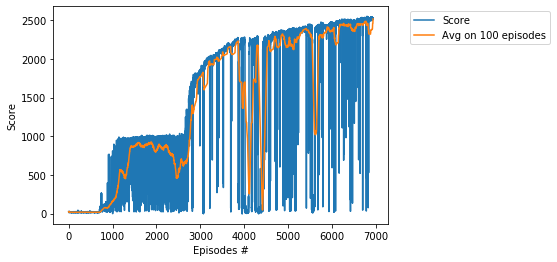

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 2570.30,	Score: 2570.30 	Time: 00:00:04
Episode 1	Average Score: 2563.39,	Score: 2556.48 	Time: 00:00:04
Episode 2	Average Score: 2562.13,	Score: 2559.60 	Time: 00:00:04
Episode 3	Average Score: 2562.28,	Score: 2562.73 	Time: 00:00:04
Episode 4	Average Score: 2564.08,	Score: 2571.31 	Time: 00:00:04
Episode 5	Average Score: 2562.61,	Score: 2555.26 	Time: 00:00:04


In [8]:
env.close()